#**Install Packages**

In [ ]:
!pip install langcodes
!pip install iso639-lang
!pip uninstall prophet pystan -y
!pip install prophet
!pip install cmdstanpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 7.8 MB/s eta 0:00:00
Found existing installation: prophet 1.3.0
Uninstalling prophet-1.3.0:
  Successfully uninstalled prophet-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 90.9 MB/s eta 0:00:00


#**Import Libraries:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

import warnings
warnings.filterwarnings('ignore')
##
import gdown
from langcodes import tag_is_valid
from iso639 import Lang

In [ ]:
from functools import partial
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet

#**Import Data:**

In [3]:
def load_data(train_path, exog_path):
    train_df = pd.read_csv(train_path)
    exog_df = pd.read_csv(exog_path)
    return train_df, exog_df

train_df, exog_df =load_data('./data/train_1.csv', './data/Exog_Campaign_eng.csv')

#**Helper Functions**

In [ ]:
def missing_values(df):
    '''
      Calculates the count and percentage of missing values for each column in a DataFrame.

      Args:
          df (pd.DataFrame): The input pandas DataFrame.

      Returns:
          pd.DataFrame: A DataFrame with two columns: 'Missing Values' (count)
                        and 'Percentage (%)' (percentage of missing values).
    '''
    missing_count=df.isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage (%)': missing_percentage
    })
    return missing_data

In [ ]:
def parse_page_name(page_name,domain_pattern=r'(\.wikipedia\.org_)'):
    """
    Parses a Wikipedia page name string to extract specific components.

    The function attempts to split the page name by common Wikipedia domain patterns ('.wikipedia.org_') to extract:
    - SPECIFIC NAME: The main title of the page.
    - LANGUAGE: The language code (e.g., 'zh', 'en').
    - ACCESS TYPE: The type of access (e.g., 'all-access', 'desktop').
    - ACCESS ORIGIN: The origin of access (e.g., 'spider', 'agent').

    Args:
        page_name (str): The full page name string from the 'Page' column.
        domain_pattern (str): Delimeter for wikipedia.

    Returns:
        tuple: A tuple containing four elements: (specific_name, language, access_type, access_origin).
               Each element will be None if it cannot be extracted or page_name itself if no domains are found.
    """
    try:

        parts = re.split(domain_pattern, page_name)
        if len(parts) < 2:
            return page_name , None, None, None
        else:
            #print(f"parts: {parts}")
            specific_name_with_lang_prefix = parts[0]
            rest_of_string = parts[-1]
            lang_match = re.split(r'[_.\\]', specific_name_with_lang_prefix)[-1]
            if tag_is_valid(lang_match):
                language = lang_match
            else:
                language = None
            if language:
                specific_name = specific_name_with_lang_prefix[:-(len(language)+1)]
            else:
                specific_name = specific_name_with_lang_prefix

            access_parts = rest_of_string.split('_')
            #print(access_parts)
            access_type = access_parts[0] if len(access_parts) > 0 else None
            access_origin = access_parts[1] if len(access_parts) > 1 else None

            return specific_name, language, access_type, access_origin

    except Exception as e:
        #print(f"Error parsing page name: {e}")
        return page_name, None, None, None

# **Exploratory Data Analysis**

---

## **Basic Exploration: train**

In [ ]:
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [ ]:
train_df.shape

(145063, 551)

In [ ]:
train_df.columns

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=551)

In [ ]:
#timeperiod
timeperiods=train_df.columns[1:]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [ ]:
train_df.describe()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,1.243230e+05,1.242470e+05,1.245190e+05,1.244090e+05,1.244040e+05,1.245800e+05,1.243990e+05,1.247690e+05,1.248190e+05,1.247210e+05,...,1.412100e+05,1.414790e+05,1.418740e+05,1.413190e+05,1.411450e+05,1.413620e+05,1.412410e+05,1.412370e+05,1.414280e+05,1.415980e+05
mean,1.195857e+03,1.204004e+03,1.133676e+03,1.170437e+03,1.217769e+03,1.290273e+03,1.239137e+03,1.193092e+03,1.197992e+03,1.189651e+03,...,1.394096e+03,1.377482e+03,1.393099e+03,1.523740e+03,1.679607e+03,1.678302e+03,1.633966e+03,1.684308e+03,1.467943e+03,1.478282e+03
std,7.275352e+04,7.421515e+04,6.961022e+04,7.257351e+04,7.379612e+04,8.054448e+04,7.576288e+04,6.820002e+04,7.149717e+04,7.214536e+04,...,8.574880e+04,7.732794e+04,8.478533e+04,8.752210e+04,9.794534e+04,9.232482e+04,9.185831e+04,9.014266e+04,8.155481e+04,8.873567e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,1.300000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.100000e+01,1.300000e+01,1.300000e+01,1.400000e+01,1.400000e+01,...,2.200000e+01,2.200000e+01,2.000000e+01,2.100000e+01,2.200000e+01,2.300000e+01,2.400000e+01,2.300000e+01,2.300000e+01,2.100000e+01
50%,1.090000e+02,1.080000e+02,1.050000e+02,1.050000e+02,1.130000e+02,1.130000e+02,1.150000e+02,1.170000e+02,1.150000e+02,1.130000e+02,...,1.490000e+02,1.430000e+02,1.320000e+02,1.450000e+02,1.600000e+02,1.620000e+02,1.630000e+02,1.600000e+02,1.540000e+02,1.360000e+02
75%,5.240000e+02,5.190000e+02,5.040000e+02,4.870000e+02,5.400000e+02,5.550000e+02,5.510000e+02,5.540000e+02,5.490000e+02,5.450000e+02,...,6.070000e+02,5.980000e+02,5.690000e+02,6.280000e+02,6.590000e+02,6.680000e+02,6.540000e+02,6.490000e+02,6.350000e+02,5.610000e+02
max,2.038124e+07,2.075219e+07,1.957397e+07,2.043964e+07,2.077211e+07,2.254467e+07,2.121089e+07,1.910791e+07,1.999385e+07,2.020182e+07,...,2.420108e+07,2.253925e+07,2.505662e+07,2.586575e+07,2.834288e+07,2.691699e+07,2.702505e+07,2.607382e+07,2.436397e+07,2.614954e+07


In [ ]:
train_df.describe(include='object')

,Page
count,145063
unique,145063
top,Francisco_el_matemático_(serie_de_televisión_d...
freq,1


In [ ]:
print(f"Total Paiges: {train_df['Page'].count()}")
print(f"Unique Paiges: {train_df['Page'].nunique()}")

Total Paiges: 145063
Unique Paiges: 145063


In [ ]:
train_df.isnull().sum().sum()

np.int64(6192931)

### **Handling Missing values**

In [ ]:
missing_values(train_df)

,Missing Values,Percentage (%)
Page,0,0.000000
2015-07-01,20740,14.297236
2015-07-02,20816,14.349627
2015-07-03,20544,14.162123
2015-07-04,20654,14.237952
...,...,...
2016-12-27,3701,2.551305
2016-12-28,3822,2.634717
2016-12-29,3826,2.637475
2016-12-30,3635,2.505808


In [ ]:
#whole row is Nan or filled with 0
train_df[(train_df[timeperiods].isna() | (train_df[timeperiods] == 0.0)).all(axis=1)]  #not considering combination of 0 and nan
train_df[(train_df[timeperiods].isna()).all(axis=1)]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
117,Pristin_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,TWICEcoaster:_LANE_2_zh.wikipedia.org_all-acce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,Yuri!!!_on_ICE_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4282,陳宣儒_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4283,驚心動魄_(2000年電影)_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143523,Hidden_Figures_es.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def handle_impute_missing_values(df, timeperiod_cols):

    print(f"Source data shape: {df.shape}")

    # 1. Drop rows where ALL time-period values are NaN
    df = df.dropna(how="all", subset=timeperiod_cols)
    print(f"Data shape after dropna(how='all'): {df.shape}")

    # 2. Drop rows where All time-period values are NaN or 0.0
    mask_all_nan_or_zero = (
       df[timeperiod_cols].isna() | (df[timeperiod_cols] == 0.0)
    ).all(axis=1)

    df = df.loc[~mask_all_nan_or_zero]
    print(f"Data shape after removing all NaN/0 rows: {df.shape}")

    # 3. Drop rows with fewer than 300 non-NaN values
    df = df.dropna(thresh=300)
    print(f"Data shape after dropna(thresh=300): {df.shape}")

    # 4. Impute missing values
    #    - Linear interpolation for internal gaps
    #    - 0.0 for leading and trailing NaNs
    #df[timeperiod_cols] = (
    #    df[timeperiod_cols]
    #    .interpolate(axis=1, method="linear", limit_area="inside")
    #    .fillna(0.0)
    #)

    return df



clean_train_df = train_df.copy(deep=True)
clean_train_df = handle_impute_missing_values(
    df=train_df,
    timeperiod_cols=timeperiods
)


Source data shape: (145063, 551)
Data shape after dropna(how='all'): (144411, 551)
Data shape after removing all NaN/0 rows: (144311, 551)
Data shape after dropna(thresh=300): (133601, 551)


In [ ]:
missing_values(clean_train_df)

,Missing Values,Percentage (%)
Page,0,0.000000
2015-07-01,9665,7.234227
2015-07-02,9682,7.246952
2015-07-03,9441,7.066564
2015-07-04,9560,7.155635
...,...,...
2016-12-27,889,0.665414
2016-12-28,931,0.696851
2016-12-29,947,0.708827
2016-12-30,928,0.694606


In [ ]:
clean_train_df.isna().sum().sum()

np.int64(1575679)

**Observations:**

* There are 145063 entries with 551 columns, i.e. 145063 wikipedia pages with views for 550 days.
* There are no duplicates as Page names are different.


* **Missing Value Observations:**
  * There are missing values in each of the dates.
  * Dropped rows that have only NaN values, or combination of NaN and 0.
  * We have made a threshold of 300(~55%) datapoints are not null.

## **Basic Exploration: Exog Campaign**

In [ ]:
exog_df.head()

,Exog
index,
2015-07-01,0
2015-07-02,0
2015-07-03,0
2015-07-04,0
2015-07-05,0


In [ ]:
exog_df.shape

(550, 1)

In [ ]:
exog_df.columns

Index(['Exog'], dtype='object')

In [ ]:
exog_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 8.6 KB


In [ ]:
exog_df.describe()

,Exog
count,550.000000
mean,0.098182
std,0.297831
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
print(f"Total Paiges: {exog_df.count()}")
print(f"Unique Paiges: {exog_df.nunique()}")

Total Paiges: Exog    550
dtype: int64
Unique Paiges: Exog    2
dtype: int64


In [ ]:
exog_df['Exog'].unique()

array([0, 1])

In [ ]:
exog_df.isnull().sum().sum()

np.int64(0)

In [ ]:
missing_values(exog_df)

,Missing Values,Percentage (%)
Exog,0,0.0


In [ ]:
exog_df['index']=timeperiods
exog_df['index'] = pd.to_datetime(exog_df['index'])
exog_df = exog_df.set_index('index')
exog_df = exog_df.asfreq('D')
exog_df

,Exog
index,
2015-07-01,0
2015-07-02,0
2015-07-03,0
2015-07-04,0
2015-07-05,0
...,...
2016-12-27,1
2016-12-28,1
2016-12-29,1


**Observations:**

* There are 550 entries with 1 columns, i.e. 550 entries for corresponding time series in train dataset.
* There are no missing values.
* There are 2 unique values- 0 and 1.

##**1.1 Feature Engineering: Page Name**
---

In [ ]:
def parse_name_analysis(df, column_name,domain_pattern):
    parse_wiki = partial(parse_page_name, domain_pattern=domain_pattern)
    data = df[column_name].apply(parse_wiki)
    df[['title', 'language', 'access_type', 'access_origin']] = pd.DataFrame(data.tolist(), index=df.index)
    df["domain"] = (df[column_name].str.extract(domain_pattern).fillna("Unknown"))
    return df[['Page','title', 'language', 'access_type', 'access_origin','domain']]


In [ ]:
df=parse_name_analysis(df=clean_train_df.copy(),column_name='Page',domain_pattern=r'(\.wikipedia\.org_|\.wikimedia\.org_|_www\.mediawiki\.org_)')
df[df['language']=='en'].groupby('domain').count()

,Page,title,language,access_type,access_origin
domain,,,,,
.wikipedia.org_,22474,22474,22474,22474,22474


In [ ]:
#language
df=parse_name_analysis(df=clean_train_df.copy(),column_name='Page',domain_pattern=r'(\.wikipedia\.org_|\.wikimedia\.org_|_www\.mediawiki\.org_)')
df.groupby(['domain'])['language'].unique()

,language
domain,
.wikimedia.org_,[None]
.wikipedia.org_,"[zh, fr, en, ru, de, ja, es]"
_www.mediawiki.org_,"[API, None, png, in, URL, hub, Git, bug, kit, ..."


In [ ]:
#df=parse_name_analysis(df=clean_train_df.copy(),column_name='Page',domain_pattern=r'(_www\.mediawiki\.org_)')
print(df[df['domain']=='_www.mediawiki.org_']['language'].unique())

['API' None 'png' 'in' 'URL' 'hub' 'Git' 'bug' 'kit' 'bis' 'XSS' 'txt'
 'css' 'map' 'net' 'Set' 'bot' 'Qqx']


In [ ]:
df.groupby(['domain'])['access_type'].unique()

,access_type
domain,
.wikimedia.org_,"[all-access, mobile-web, desktop]"
.wikipedia.org_,"[all-access, desktop, mobile-web]"
_www.mediawiki.org_,"[all-access, mobile-web, desktop]"


In [ ]:
df.groupby(['domain'])['access_origin'].unique()

,access_origin
domain,
.wikimedia.org_,"[spider, all-agents]"
.wikipedia.org_,"[spider, all-agents]"
_www.mediawiki.org_,"[all-agents, spider]"


In [ ]:
en_train_df=parse_name_analysis(df=clean_train_df.copy(),column_name='Page',domain_pattern=r'(\.wikipedia\.org_)')
en_train_df[en_train_df['language']=='en'].groupby('domain').count()

,Page,title,language,access_type,access_origin
domain,,,,,
.wikipedia.org_,22474,22474,22474,22474,22474


In [ ]:
#train_df2=clean_train_df.copy()
domain_pattern=r'(\.wikipedia\.org_|\.wikimedia\.org_|_www\.mediawiki\.org_)'      # put you domain patters here


parse_wiki = partial(parse_page_name, domain_pattern=domain_pattern)
data = clean_train_df['Page'].apply(parse_wiki)
clean_train_df[['title', 'language', 'access_type', 'access_origin']] = pd.DataFrame(data.tolist(), index=clean_train_df.index)
clean_train_df["domain"] = (df['Page'].str.extract(domain_pattern).fillna("Unknown"))


train_df2=clean_train_df[clean_train_df["domain"]!='Unknown']
print(f"Unique languages: {train_df2[train_df2['domain']=='.wikipedia.org_']['language'].unique()}")
print(f"Unique Access Type: {train_df2[train_df2['domain']=='.wikipedia.org_']['access_type'].unique()}")
print(f"Unique Access Origin: {train_df2[train_df2['domain']=='.wikipedia.org_']['access_origin'].unique()}")

Unique languages: ['zh' 'fr' 'en' 'ru' 'de' 'ja' 'es']
Unique Access Type: ['all-access' 'desktop' 'mobile-web']
Unique Access Origin: ['spider' 'all-agents']


**Observations:**

* We have three sets of wiki source .wikimedia.org_, .wikipedia.org_ and _www.mediawiki.org_.
* There is format in-consistency for the other two as well other than wikipedia.org_. Need better data cleaning.
---
* For .wikipedia.org_
  * Unique languages: ['zh' 'fr' 'en' 'ru' 'de' 'ja' 'es']
  * Unique Access Type: ['all-access' 'desktop' 'mobile-web']
  * Unique Access Origin: ['spider' 'all-agents']


In [ ]:
lang_name_mapping={'zh':'Chinese', 'fr':'French', 'en':'English',
                   'ru':'Russian', 'de':'German',
                   'ja':'Japanese', 'es':'Spanish'}
train_df2['language'] = train_df2['language'].map(lang_name_mapping).fillna("Unknown")

##**1.2. Univariate Analysis:**
---

In [ ]:
language_counts = train_df2['language'].value_counts()
language_percentages = (train_df2['language'].value_counts(normalize=True) * 100).round(2)

plot_df = pd.DataFrame({
    'Language': language_counts.index,
    'Number of Pages': language_counts.values,
    'Percentage': language_percentages.values
})

fig = px.bar(plot_df, x='Language', y='Number of Pages',
             title='Number of Pages and Percentage in Different Languages',
             labels={'Number of Pages': 'Number of Pages'},
             text='Percentage')

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show()

**Observations:**
* Most of the pages are English(16.82%), followed by Japanese(14.44%).

In [ ]:
access_type_counts = train_df2['access_type'].value_counts()
access_type_percentages = (train_df2['access_type'].value_counts(normalize=True) * 100).round(2)

plot_df = pd.DataFrame({
    'Access Type': access_type_counts.index,
    'Number of Pages': access_type_counts.values,
    'Percentage': access_type_percentages.values
})

fig = px.bar(plot_df, x='Access Type', y='Number of Pages',
             title='Number of Pages and Percentage by Access Type',
             labels={'Number of Pages': 'Number of Pages'},
             text='Percentage')

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show()

**Observations:**

* Around 51.42% of the access type is All Access.
* Mobile Web and Desktop is more or less same, around 24%.

In [ ]:
access_origin_counts = train_df2['access_origin'].value_counts()
access_origin_percentages = (train_df2['access_origin'].value_counts(normalize=True) * 100).round(2)

plot_df = pd.DataFrame({
    'Access Origin': access_origin_counts.index,
    'Number of Pages': access_origin_counts.values,
    'Percentage': access_origin_percentages.values
})

fig = px.bar(plot_df, x='Access Origin', y='Number of Pages',
             title='Number of Pages and Percentage by Access Origin',
             labels={'Number of Pages': 'Number of Pages'},
             text='Percentage')

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show()

**Obserbations:**

* With dominance of around 76% Access Origin is All agents. And around 24% is spider.

##**1.3. Bivariate Analysis:**
---

In [ ]:
lang_access_origin_counts = train_df2.groupby(['language', 'access_origin']).size().reset_index(name='count')

lang_access_origin_counts['percentage'] = lang_access_origin_counts.groupby('language')['count'].transform(lambda x: (x / x.sum()) * 100).round(2)

fig = px.bar(lang_access_origin_counts,
             x='language',
             y='count',
             color='access_origin',
             title='Access Origin by Language',
             labels={'language': 'Language', 'count': 'Number of Pages', 'access_origin': 'Access Origin'},
             barmode='group',
             text='percentage') # Use the calculated percentage for text labels

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside') # Format text as percentage and place outside
fig.update_layout(xaxis_title='Language', yaxis_title='Number of Pages')
fig.show()

**Observations:**

* Across all the the languages the Access Origin is All agents with approx value of 75%.

##**1.4. Time series plots for all languages:**
**Assumption**: The below analysis is for .wikipedia.org_
---

In [ ]:
df_agg = train_df2.drop(columns=['Page', 'title', 'access_type', 'access_origin', 'domain']).groupby('language').sum().T.reset_index()
df_agg['index'] = pd.to_datetime(df_agg['index'])
df_agg = df_agg.set_index('index')
df_agg = df_agg.asfreq('D')
df_agg.drop(columns=['Unknown'],inplace=True)
df_agg.tail()

language,Chinese,English,French,German,Japanese,Russian,Spanish
index,,,,,,,
2016-12-27,5522612.0,141984143.0,14246323.0,19438442.0,15600807.0,14246798.0,14512083.0
2016-12-28,5613615.0,137364144.0,13280205.0,18443376.0,15579365.0,13485931.0,15028015.0
2016-12-29,5179746.0,146565064.0,12934869.0,17951250.0,17052010.0,12976456.0,14345906.0
2016-12-30,5213499.0,121464703.0,12041601.0,17045776.0,18895184.0,11636830.0,10943126.0
2016-12-31,5357075.0,118740549.0,11085020.0,16282828.0,23708168.0,12880105.0,10528237.0


In [ ]:
fig = px.line(df_agg,
              x=df_agg.index,
              y=df_agg.columns,
              title='Average Number of Page Views Over Time by Language',
              labels={'index': 'Date', 'value': 'Average Number of Visits', 'variable': 'Language'})

fig.update_layout(xaxis_title='Date', yaxis_title='No. of visits')
fig.show()

**Observations:**

* English pages are the most visited pages follwed by Spanish
* There is an unusual peak from mid of July to mid of August 2016

In [ ]:
lang_sum = (
    df_agg
    .sum()
    .reset_index()
)

lang_sum.columns = ["language", "total_views"]
lang_sum["share_pct"] = ( lang_sum["total_views"] / lang_sum["total_views"].sum() * 100 )
lang_sum_sorted = lang_sum.sort_values("total_views", ascending=False)

fig = px.bar(
    lang_sum_sorted,
    x="language",
    y="total_views",
    text=lang_sum_sorted["share_pct"].round(2).astype(str) + "%",
    title="Total Wikipedia Views by Language (with Share %)"
)

fig.update_traces(
    textposition="outside",
    hovertemplate=(
        "<b>%{x}</b><br>"
        "Total Views: %{y:,}<br>"
        "Share: %{customdata:.2f}%"
    ),
    customdata=lang_sum_sorted["share_pct"]
)

fig.update_layout(
    xaxis_title="Language",
    yaxis_title="Total Views",
    template="plotly_white",
    uniformtext_minsize=10,
    uniformtext_mode="hide"
)

fig.show()


In [ ]:
df_q = df_agg.copy()
df_q.index = pd.to_datetime(df_q.index)


df_qtr = df_q.resample("Q").sum()

df_qtr_long = (
    df_qtr
    .reset_index()
    .melt(id_vars="index", var_name="language", value_name="total_views")
)

df_qtr_long.rename(columns={"index": "quarter"}, inplace=True)

df_qtr_long["quarter"] = df_qtr_long["quarter"].dt.to_period("Q").astype(str)

In [ ]:

fig = px.line(
    df_qtr_long,
    x="quarter",
    y="total_views",
    color="language",
    markers=True,
    title="Quarter-over-Quarter Wikipedia Views by Language"
)

fig.update_layout(
    xaxis_title="Quarter",
    yaxis_title="Total Views",
    template="plotly_white",
    legend_title="Language"
)

fig.show()


In [ ]:

fig = px.line(
    df_qtr_long[df_qtr_long['language']!='English'],
    x="quarter",
    y="total_views",
    color="language",
    markers=True,
    title="Quarter-over-Quarter Wikipedia Views by Language(Except English)"
)

fig.update_layout(
    xaxis_title="Quarter",
    yaxis_title="Total Views",
    template="plotly_white",
    legend_title="Language"
)

fig.show()


**Obserbations:**
* English views are 5–7× higher than any other language and show clear seasonal peaks (Q3) and sharp volume swings.
* Russian traffic is highly volatile, indicating event-driven behavior
* Spanish consistently leads non-English languages in total views while maintaining low volatility and steady growth. This makes it a high-confidence, high-ROI language segment for sustained ad placement and reliable forecast-based optimization.


#**2. ADF - Checking stationarity**
---

Using Augmented Dickey-Fuller test to check for stationarity

**Null Hypothesis H0:** The series is not stationary

**Alternate Hypothesis H1:** The series is stationary

**Significance Value alpha:** 0.05

---

In [ ]:
def adf_test(df,p_value_threshold=0.05):
    test_result=sm.tsa.stattools.adfuller(df)
    print(f"ADF Statistic: {test_result[0]}")
    pvalue=test_result[1]
    print(f"p-value: {pvalue}")
    if pvalue < p_value_threshold:
        print("The series is stationary")
    else:
        print("The series is not stationary")

In [ ]:
for lang in df_agg.columns:
    print(f"Language: {lang}")
    adf_test(df_agg[lang])
    print()
    print('-----------------------------------------')

Language: Chinese
ADF Statistic: -1.921665869672913
p-value: 0.321938441956511
The series is not stationary

-----------------------------------------
Language: English
ADF Statistic: -2.373562974569931
p-value: 0.14933749437355603
The series is not stationary

-----------------------------------------
Language: French
ADF Statistic: -2.920997420875076
p-value: 0.04296020201712343
The series is stationary

-----------------------------------------
Language: German
ADF Statistic: -2.40599924709918
p-value: 0.14005032008361074
The series is not stationary

-----------------------------------------
Language: Japanese
ADF Statistic: -2.71006577094465
p-value: 0.07231258891846545
The series is not stationary

-----------------------------------------
Language: Russian
ADF Statistic: -3.9394018287252552
p-value: 0.0017632662037636957
The series is stationary

-----------------------------------------
Language: Spanish
ADF Statistic: -2.9283378865291603
p-value: 0.04215053463615008
The series

**Observations:**
Based on adf test
* **Stationary:** French, Russian and Spanish.
* **Not Stationary:** Chinese, English, German and Japanese

# **Moving forward we will consider English Language**
___

**Note:**
* English language is not stationary

In [ ]:
df_agg_en=df_agg['English']
df_agg_en.index = pd.to_datetime(df_agg_en.index)
df_agg_en = df_agg_en.asfreq('D')
df_agg_en.head()

,English
index,
2015-07-01,84712151.0
2015-07-02,84438500.0
2015-07-03,80167665.0
2015-07-04,83463151.0
2015-07-05,86198575.0


<Axes: xlabel='index'>

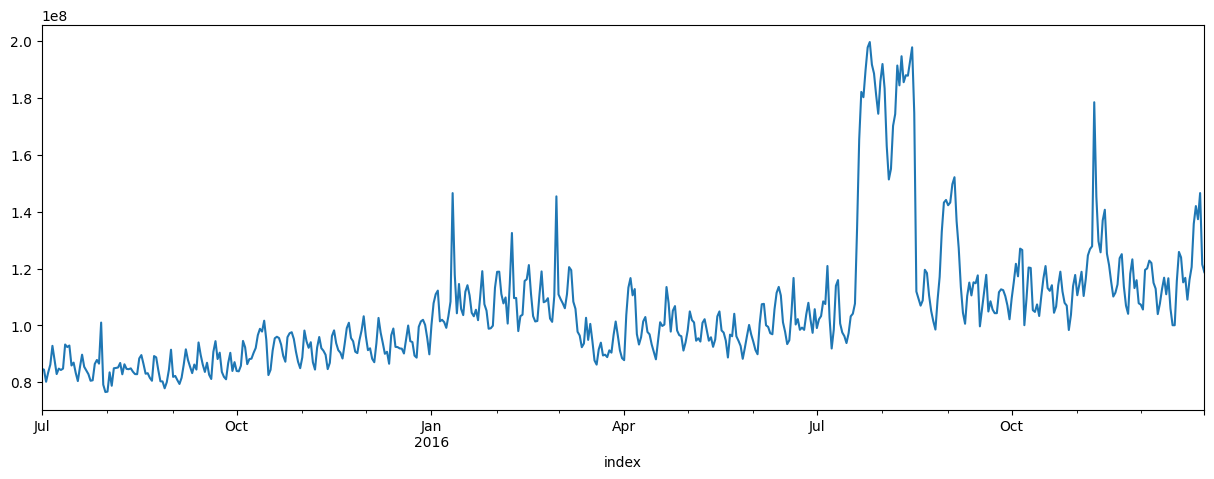

In [ ]:
df_agg_en.plot(figsize=(15, 5))

ADF Statistic: -8.273590058493813
p-value: 4.721271966433727e-13
The series is stationary


<Axes: xlabel='index'>

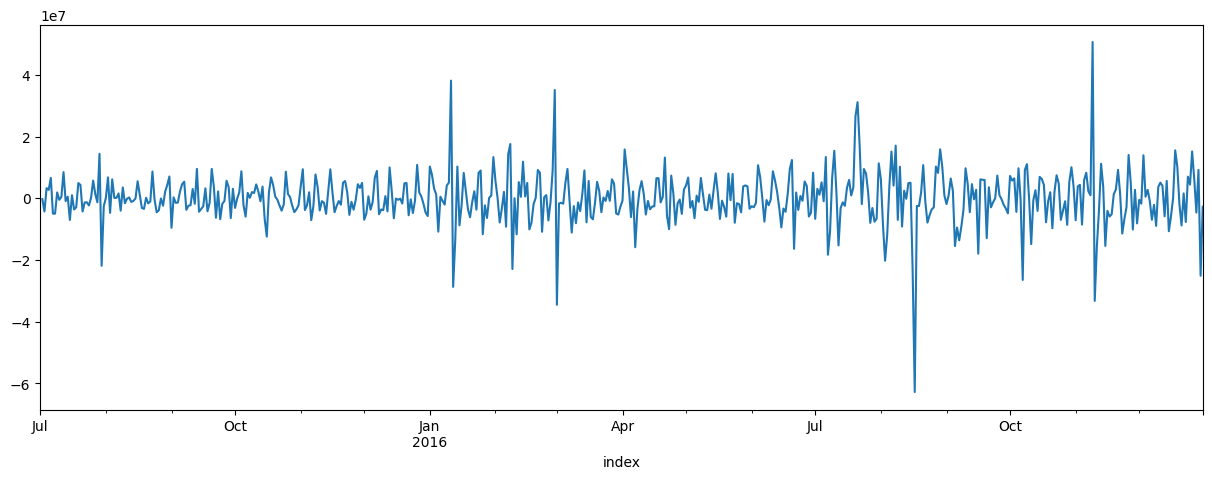

In [ ]:
#detrending
df_agg_en_detrended = df_agg_en.diff(1)
adf_test(df_agg_en_detrended.dropna())
df_agg_en_detrended.plot(figsize=(15, 5))

**Observations:**

* Initially English language was not stationary but after 1 difference it is stationary.

## **3. Decomposition**

In [ ]:
def plot_seasonal_decomposition(df, title):
    decom = sm.tsa.seasonal_decompose(df)
    df_trend = decom.trend
    df_season = decom.seasonal
    df_noise = decom.resid
    plt.figure(figsize=(15,8))
    plt.title(title)
    plt.subplot(411)
    plt.plot(df_agg_en, label='actual')
    plt.legend()
    plt.subplot(412)
    plt.plot(df_trend, label='trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(df_season, label='seasonal')
    plt.legend()
    plt.subplot(414)
    plt.plot(df_noise, label='residual')
    plt.legend()
    plt.tight_layout()
    plt.show()

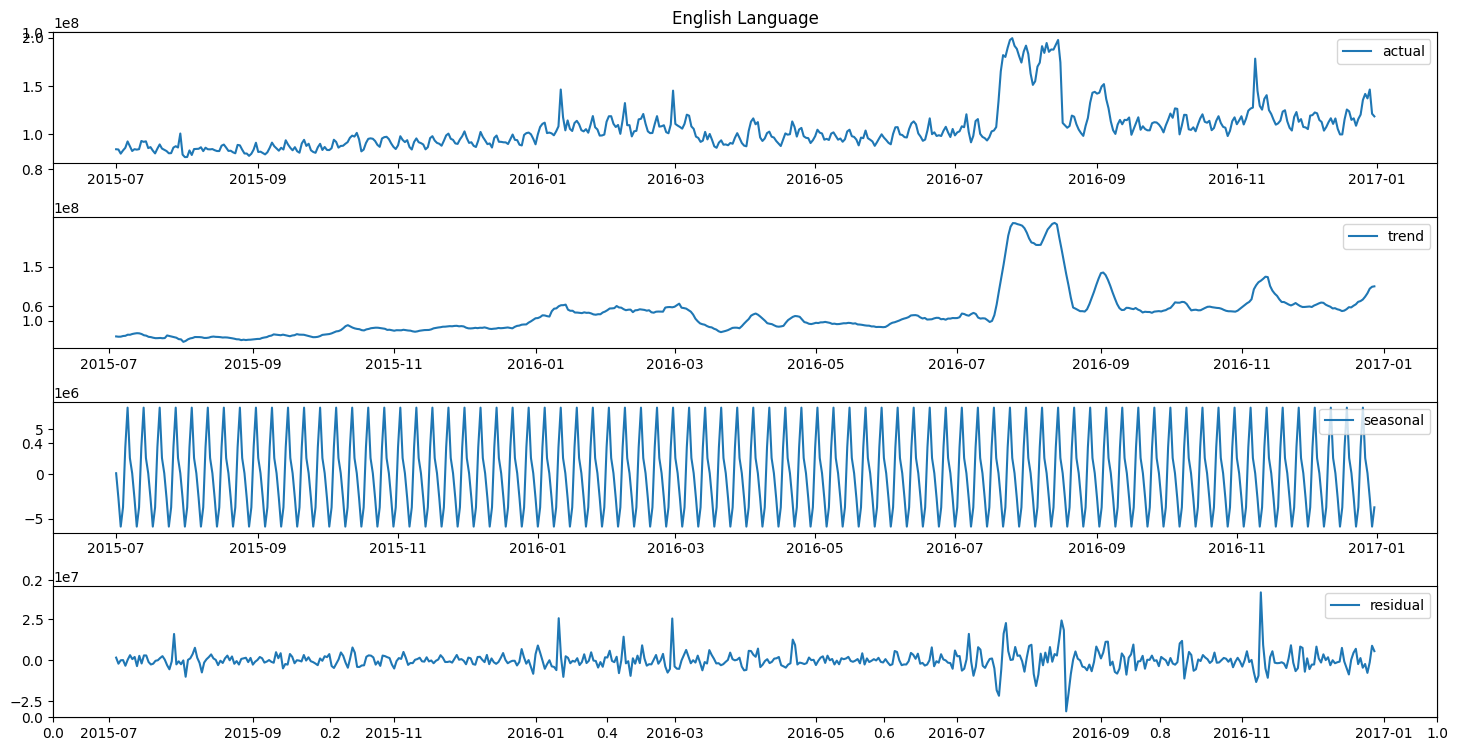

In [ ]:
plot_seasonal_decomposition(df=df_agg_en,title='English Language')

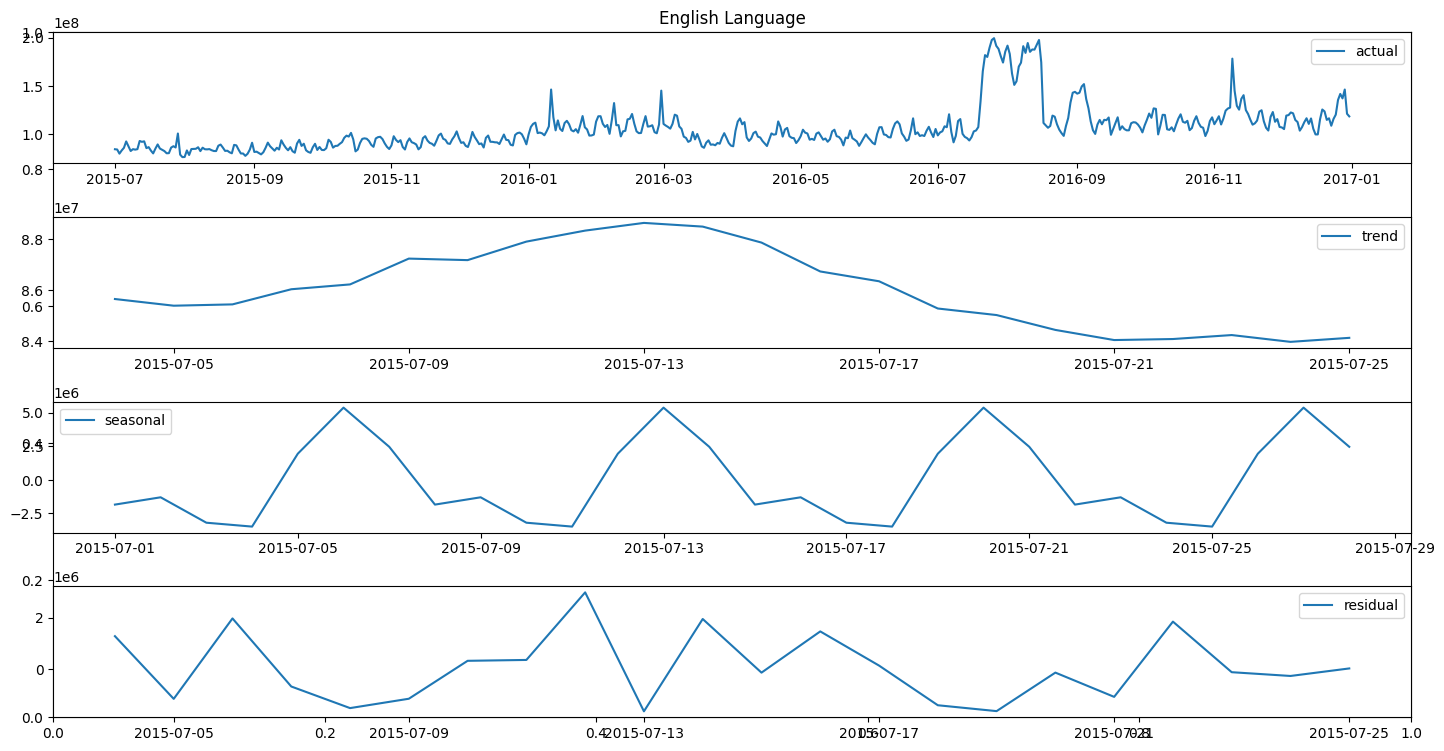

In [ ]:
plot_seasonal_decomposition(df=df_agg_en[0:28],title='English Language')


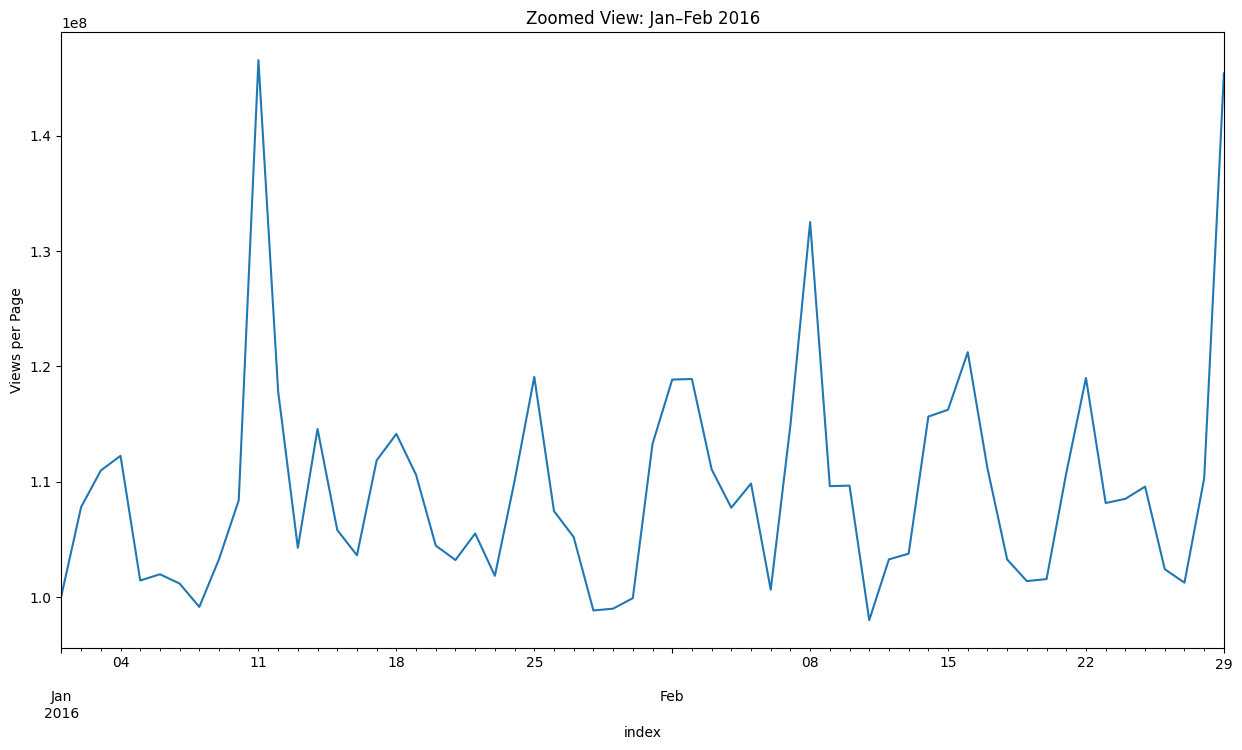

In [ ]:
df_agg_en['2016-01':'2016-02'].plot(figsize=(15,8))
plt.ylabel("Views per Page")
plt.title("Zoomed View: Jan–Feb 2016")
plt.show()

**Observations:**

1. For English Language:
    * Seasonality=7
    * Differencing=1 is stationary


## **4: ACF and PACF**

In [ ]:
def plot_acf_pacf(series, lags=30):
    series=series.dropna()
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series, lags=lags, ax=axes[0])
    plot_pacf(series, lags=lags, ax=axes[1])
    plt.show()

In [ ]:
df_agg_en

,English
index,
2015-07-01,84712151.0
2015-07-02,84438500.0
2015-07-03,80167665.0
2015-07-04,83463151.0
2015-07-05,86198575.0
...,...
2016-12-27,141984143.0
2016-12-28,137364144.0
2016-12-29,146565064.0


Language:   Engish Language
Differencing: 1
ADF Statistic: -8.273590058493813
p-value: 4.721271966433727e-13
The series is stationary


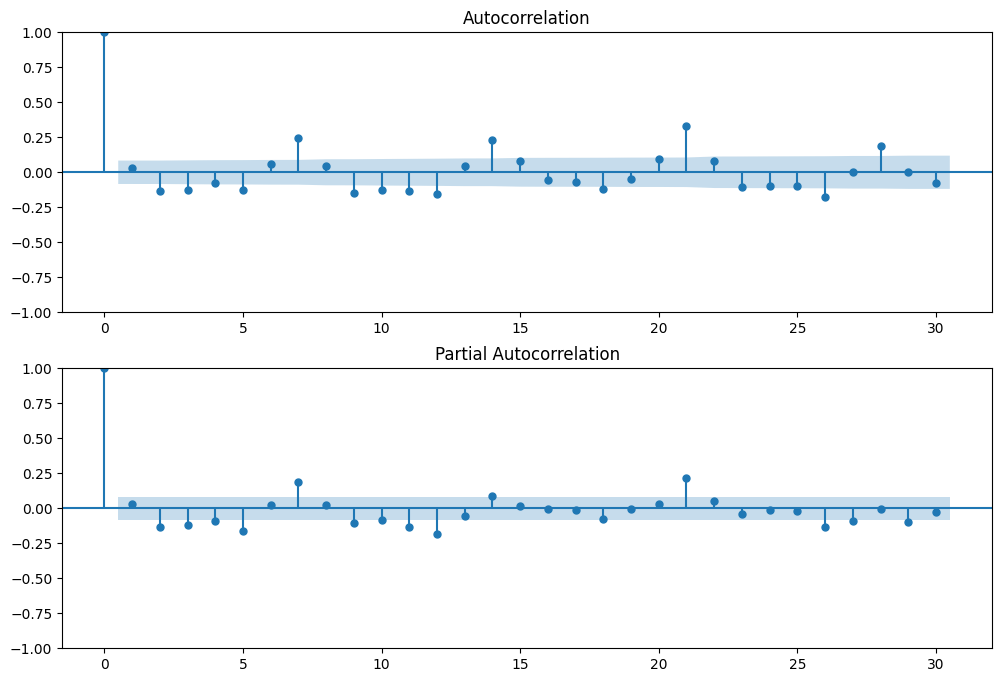

Language:   Engish Language
Differencing: 2
ADF Statistic: -5.107588247227649
p-value: 1.3534727926223895e-05
The series is stationary


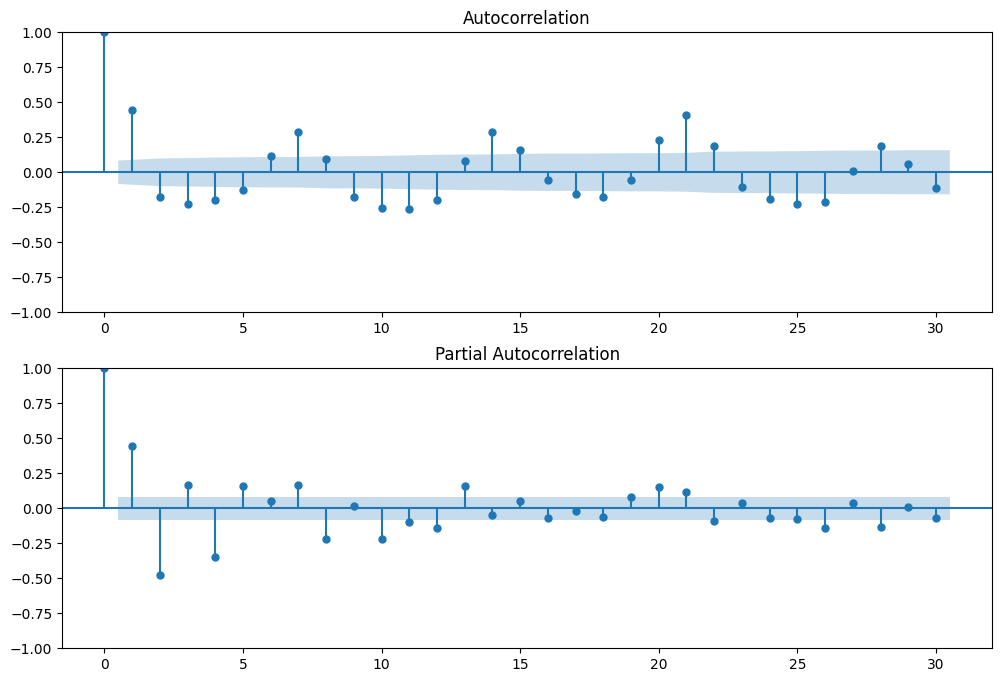

Language:   Engish Language
Differencing: 3
ADF Statistic: -4.6975792637186204
p-value: 8.503835258350492e-05
The series is stationary


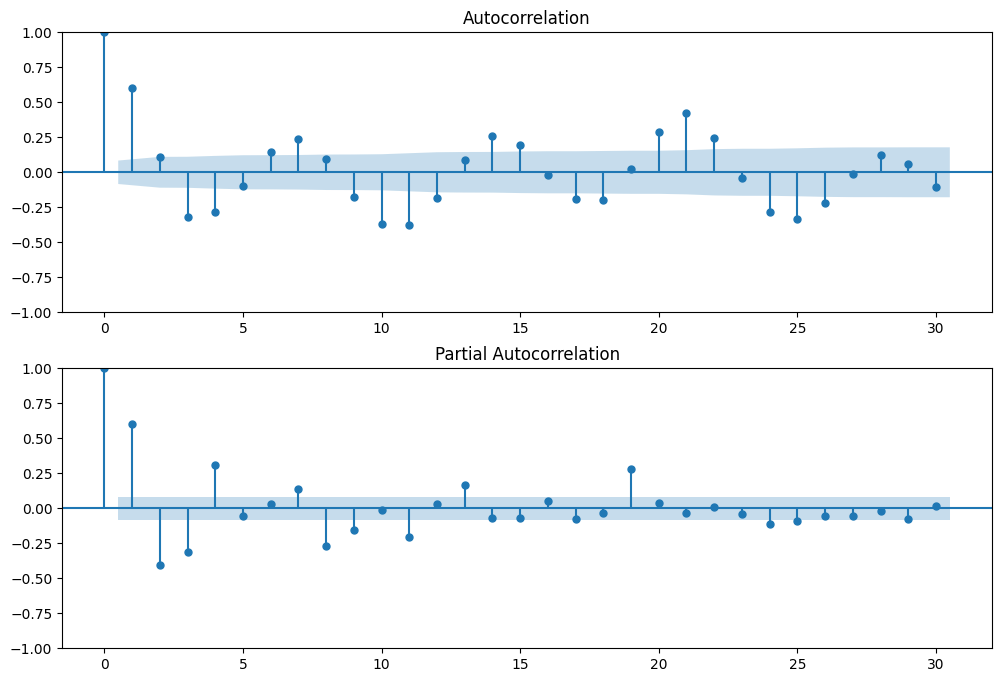

Language:   Engish Language
Differencing: 4
ADF Statistic: -4.97999641174572
p-value: 2.4307690568153164e-05
The series is stationary


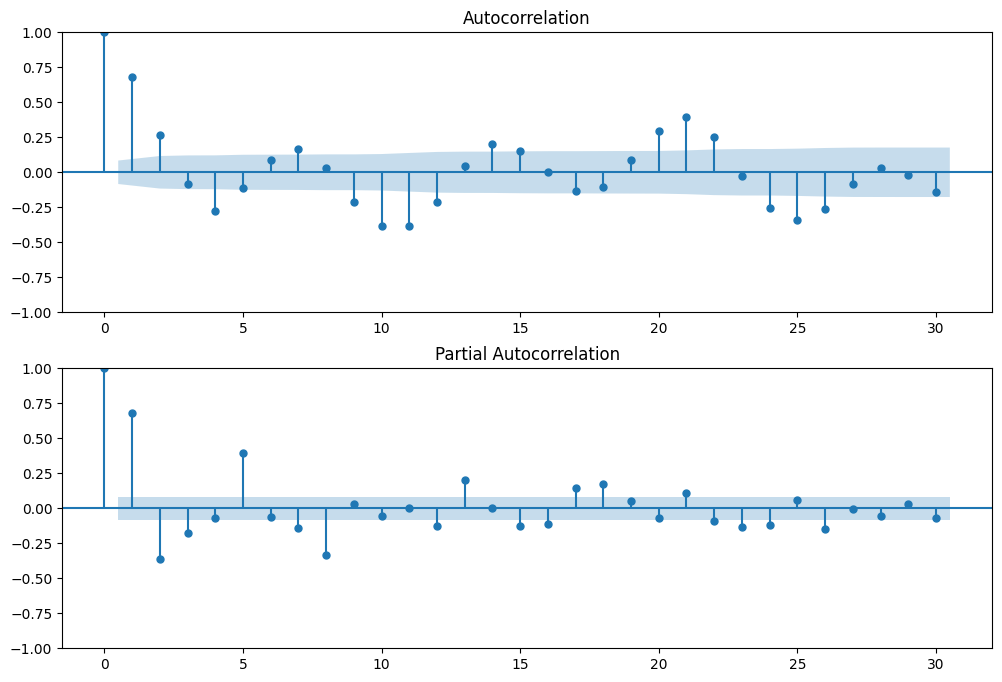

In [ ]:
for i in range(1,5):
    print("Language:   Engish Language")
    print(f"Differencing: {i}")
    df_agg_en_detrended = df_agg_en.diff(i)
    adf_test(df_agg_en_detrended.dropna())
    plot_acf_pacf(df_agg_en_detrended)

Language:   Engish Language
Differencing: 2
ADF Statistic: -5.107588247227649
p-value: 1.3534727926223895e-05
The series is stationary


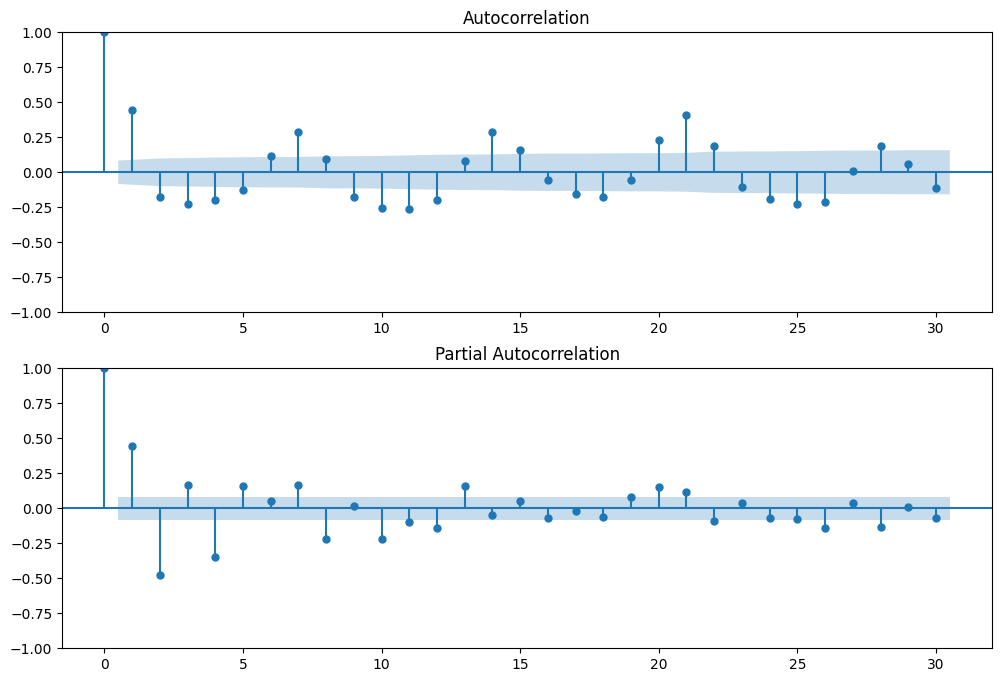

In [ ]:
print("Language:   Engish Language")
print(f"Differencing: {2}")
df_agg_en_detrended = df_agg_en.diff(2)
adf_test(df_agg_en_detrended.dropna())
plot_acf_pacf(df_agg_en_detrended)

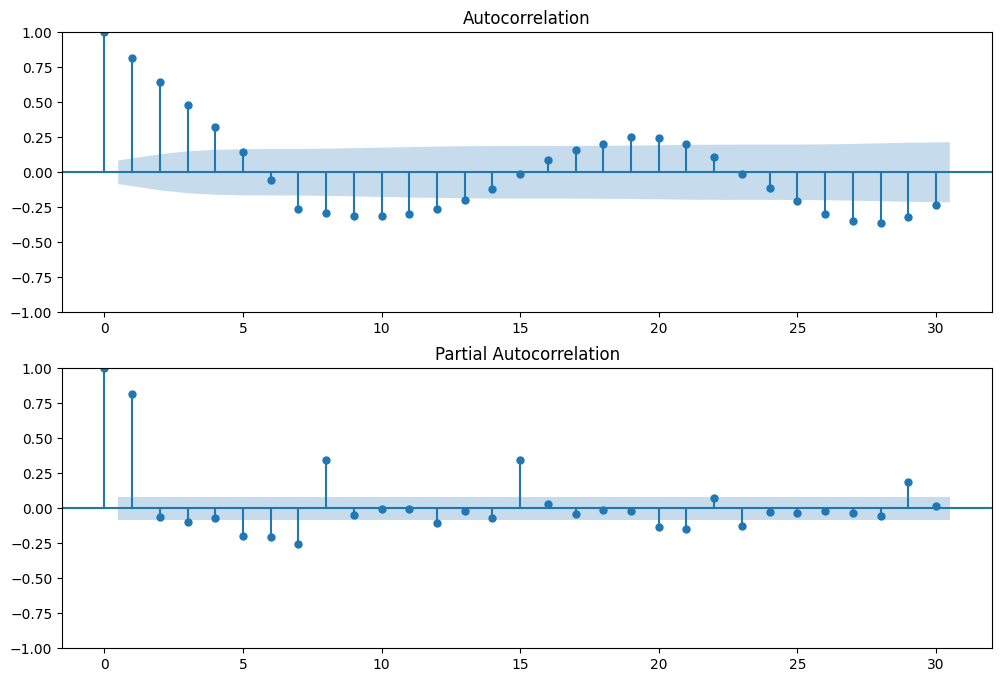

In [ ]:
#Seasonal Differencing(7)
plot_acf_pacf(df_agg_en.diff(7))

**Observations:**

* We will be going for d=2
* We have seen for ACF q=5
* We have seen for PACF p=5

* We will be going for D=1
* We have seen for ACF Q=1
* We have seen for PACF P=1
* Seasonality s=7


## **5: Train Test Split**

In [ ]:
def sequential_train_test_split(df, exog_df=None, test_split_ratio=0.2):
    """
    Sequential (time-aware) train-test split.

    df              : pandas Series or DataFrame (target)
    exog_df         : pandas DataFrame (exogenous variables)
    test_split_ratio: float (e.g., 0.2)
    """

    train_df = None
    test_df  = None
    train_exog = None
    test_exog  = None

    if df is None or len(df) == 0:
        raise ValueError("df cannot be None or empty")

    test_size = int(len(df) * test_split_ratio)

    if test_size == 0:
        raise ValueError("test_split_ratio too small for dataset size")

    train_df = df.iloc[:-test_size]
    test_df  = df.iloc[-test_size:]

    if exog_df is not None:
        train_exog = exog_df.iloc[:-test_size]
        test_exog  = exog_df.iloc[-test_size:]
        return train_df, test_df, train_exog, test_exog

    return train_df, test_df, train_exog, test_exog


In [ ]:
train_en_df, test_en_df , train_exog_df ,test_exog_df = sequential_train_test_split(df=df_agg_en,exog_df=exog_df,test_split_ratio=0.07)

In [ ]:
print(f"Train min index: {train_en_df.index.min()}, max index: {train_en_df.index.max()}, count: {len(train_en_df)}")
print(f"Test min index: {test_en_df.index.min()}, max index: {test_en_df.index.max()}, count: {len(test_en_df)}")
print("\n\n")
print(f"Exog Train min index: {train_exog_df.index.min()}, max index: {train_exog_df.index.max()}, count: {len(train_exog_df)}")
print(f"Exog Test min index: {test_exog_df.index.min()}, max index: {test_exog_df.index.max()}, count: {len(test_exog_df)}")

Train min index: 2015-07-01 00:00:00, max index: 2016-11-23 00:00:00, count: 512
Test min index: 2016-11-24 00:00:00, max index: 2016-12-31 00:00:00, count: 38



Exog Train min index: 2015-07-01 00:00:00, max index: 2016-11-23 00:00:00, count: 512
Exog Test min index: 2016-11-24 00:00:00, max index: 2016-12-31 00:00:00, count: 38


##**7. Evaluation Metrics**

In [ ]:
def evaluation_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return (mse,mae,mape)

In [ ]:
def plot_forecasted_vs_actual(y_true, y_pred, title=None):
    plt.figure(figsize=(15,8))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()

##**8. ARIMA**

In [ ]:
def fit_arima_model(train_df, p=1,d=0,q=0):
    '''
    train_df: pandas Series
    p, d, q: int
    '''
    model = SARIMAX(train_df, order=(p, d, q))
    model_fit = model.fit()
    return model_fit

##**9. SARIMAX**

In [ ]:
def fit_sarimax_model(train_df, p=1,d=0,q=0,P=0,D=0,Q=0,s=0,exog_df=None):
    '''
    train_df: pandas Series
    p, d, q: int
    P, D, Q: int
    s: int seasonality
    exog_df: pandas DataFrame
    '''
    model = SARIMAX(train_df, order=(p, d, q), seasonal_order=(P, D, Q,s), exog=exog_df)
    model_fit = model.fit(disp=False)
    return model_fit

##**10. Facebook Prophet**

In [ ]:
def train_prophet(df, exog_cols=None):
    model = Prophet(yearly_seasonality=True,weekly_seasonality=True,changepoint_prior_scale=0.8,seasonality_prior_scale=5,holidays_prior_scale=5)
    if exog_cols:
        for col in exog_cols:
            model.add_regressor(col)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(df)
    return model

##**11. Pipeline**

In [ ]:
def predict_pipeline(
    model_type: str,
    train_df,
    test_df,
    order_dict=None,
    seasonal_order_dict=None,
    forecast_steps=None,
    sx_exog_train_df=None,
    sx_exog_test_df=None,
    fb_prophet_exog_cols=None
):
    """
    model_type           : 'arima' or 'sarima'
    train_df             : pandas Series (train)
    test_df              : pandas Series (test)
    order_dict           : tuple (p, d, q)
    seasonal_order_dict  : tuple (P, D, Q, s) | required for sarima
    forecast_steps       : int (defaults to len(test_df))
    """

    if forecast_steps is None:
        forecast_steps = len(test_df)

    model_type = model_type.lower()

    # ---------------------------
    # ARIMA
    # ---------------------------
    if model_type == 'arima':
        model_fit = fit_arima_model(
            train_df=train_df,
            p=order_dict[0],
            d=order_dict[1],
            q=order_dict[2]
        )
        forecast = model_fit.forecast(steps=forecast_steps)
    # ---------------------------
    # SARIMA
    # ---------------------------
    elif model_type == 'sarima':
        if seasonal_order_dict is None:
            raise ValueError("seasonal_order_dict must be provided for SARIMA")

        model_fit = fit_sarimax_model(
            train_df=train_df,
            p=order_dict[0],
            d=order_dict[1],
            q=order_dict[2],
            P=seasonal_order_dict[0],
            D=seasonal_order_dict[1],
            Q=seasonal_order_dict[2],
            s=seasonal_order_dict[3],
            exog_df=None
        )
        forecast = model_fit.forecast(steps=forecast_steps)
    # ---------------------------
    # SARIMAX
    # ---------------------------
    elif model_type == 'sarimax':
        if seasonal_order_dict is None:
            raise ValueError("seasonal_order_dict must be provided for SARIMAX")

        model_fit = fit_sarimax_model(
            train_df=train_df,
            p=order_dict[0],
            d=order_dict[1],
            q=order_dict[2],
            P=seasonal_order_dict[0],
            D=seasonal_order_dict[1],
            Q=seasonal_order_dict[2],
            s=seasonal_order_dict[3],
            exog_df=sx_exog_train_df
        )
        forecast = model_fit.forecast(steps=forecast_steps,exog=test_exog_df)
    # ---------------------------
    # Facebook-Prophet
    # ---------------------------
    elif model_type == 'fb-prophet':
        if 'ds' not in train_df.columns or 'y' not in train_df.columns:
            raise ValueError("train_df must have 'ds' and 'y' columns")
        elif 'ds' not in test_df.columns or 'y' not in test_df.columns:
            raise ValueError("test_df must have 'ds' and 'y' columns")
        elif fb_prophet_exog_cols:
            if not all(col in train_df.columns for col in fb_prophet_exog_cols) or not all(col in test_df.columns for col in fb_prophet_exog_cols):
                raise ValueError("fb_prophet_exog_cols must be present in both train_df and test_df")

        model_fit = train_prophet(
            df=train_df,
            exog_cols=fb_prophet_exog_cols
        )
        forecast = model_fit.predict(test_df)
    else:
        raise ValueError("model_type must be either 'arima' or 'sarima' or 'sarimax' or 'fb-prophet'")


    # ---------------------------
    # Evaluation
    # ---------------------------
    if model_type == 'fb-prophet':
        y_true = test_df['y'].values
        y_pred = forecast['yhat'].values
    else:
        y_true = test_df.values
        y_pred = forecast.values

    metrics = evaluation_metrics(
        y_true=y_true,
        y_pred=y_pred
    )
    print("---------------Evaluation Metrics---------------")
    print(f"MSE: {metrics[0]}")
    print(f"MAE: {metrics[1]}")
    print(f"MAPE: {metrics[2]}")
    # ---------------------------
    # Forecast Plot
    # ---------------------------
    if model_type == 'fb-prophet':
        plot_forecasted_vs_actual(
            test_df['y'],
            forecast['yhat'],
            title=f"Model Type: {model_type.upper()}"
        )
    else:
        plot_forecasted_vs_actual(test_df,forecast,title=f"Model Type: {model_type.upper()}")

    return model_fit, forecast, metrics


##**12.Model Outcomes(English Language)**

###ARIMA

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 75223049744796.75
MAE: 6577762.161572939
MAPE: 0.05562479509279944


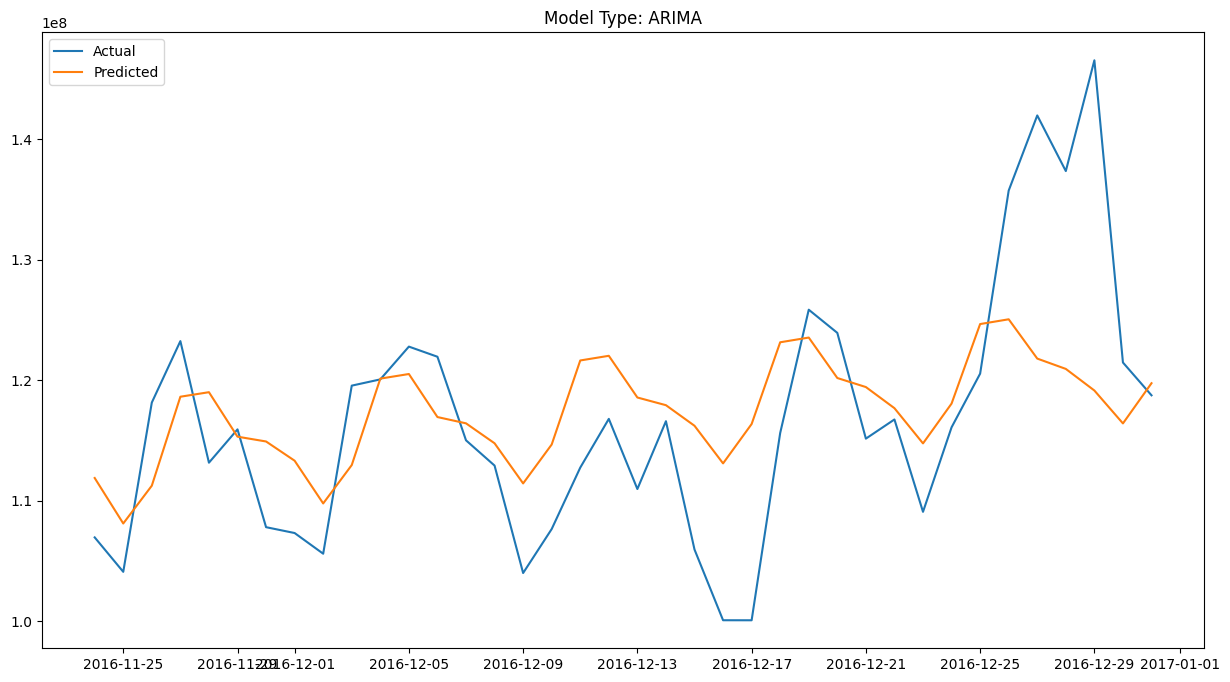

In [ ]:
#Model Arima
#p=5,d=2,q=5
model ,forecasts,metrics=predict_pipeline(model_type='arima',train_df=train_en_df, test_df=test_en_df,order_dict=(5,2,5))

###SARIMA

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 314747244700755.2
MAE: 13199652.169215294
MAPE: 0.10684027200942721


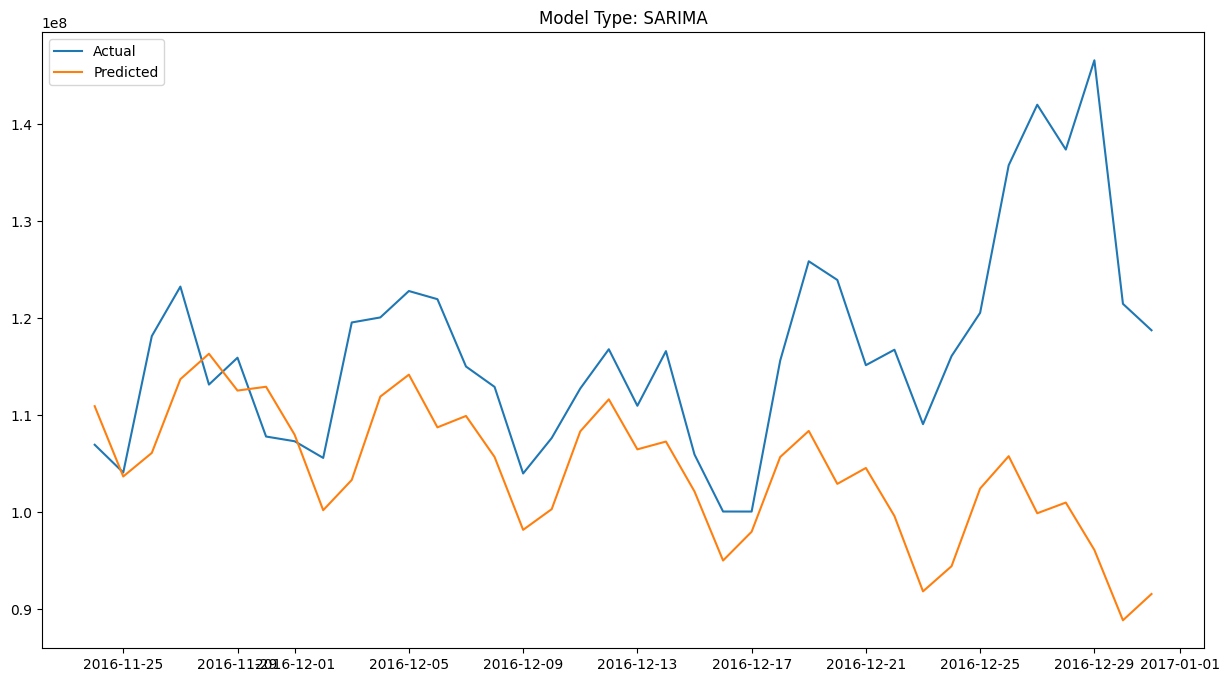

In [ ]:
#Model Sarima
#p=5,d=2,q=5 ,  P=1,D=1,Q=1,s=7
model ,forecasts,metrics=predict_pipeline(model_type='sarima',train_df=train_en_df, test_df=test_en_df,order_dict=(5,2,5),seasonal_order_dict=(1,1,1,7))

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 86417970436570.42
MAE: 7945263.159933677
MAPE: 0.06876258528493141


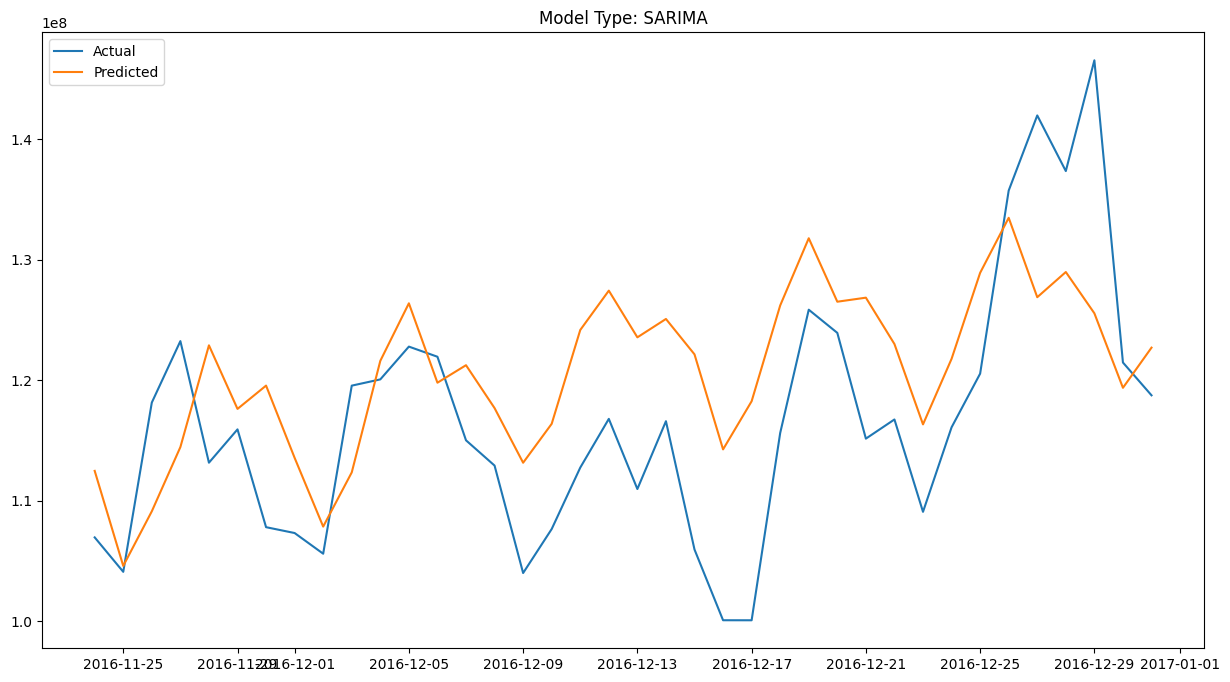

In [ ]:
#Model Sarima
#p=5,d=1,q=5 ,  P=1,D=1,Q=1,s=7
model ,forecasts,metrics=predict_pipeline(model_type='sarima',train_df=train_en_df, test_df=test_en_df,order_dict=(5,1,5),seasonal_order_dict=(1,1,1,7))

###SARIMAX

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 112875558615485.1
MAE: 8228738.175763463
MAPE: 0.06739938808810052


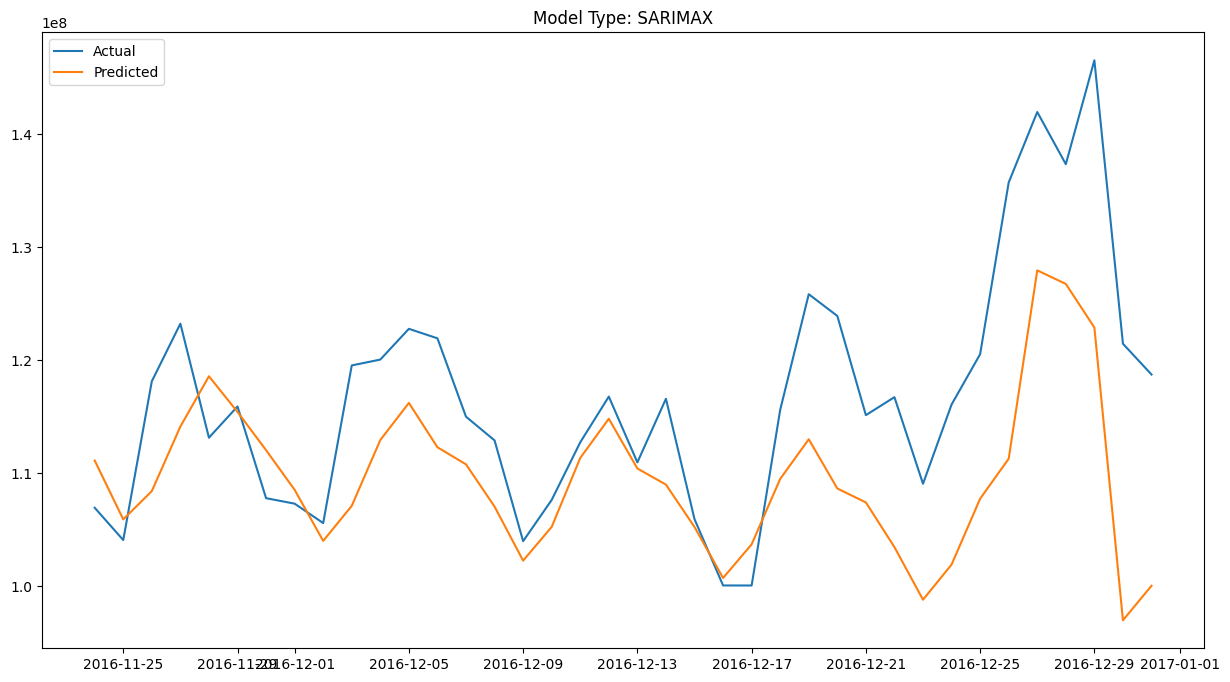

In [ ]:
#Model Sarimax
#p=5,d=2,q=5 ,  P=1,D=1,Q=1,s=7
model ,forecasts,metrics=predict_pipeline(model_type='sarimax',train_df=train_en_df, test_df=test_en_df,order_dict=(5,2,5),seasonal_order_dict=(1,1,1,7),sx_exog_train_df=train_exog_df,sx_exog_test_df=test_exog_df)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 42443216907617.945
MAE: 5367768.330600539
MAPE: 0.047173402329428515


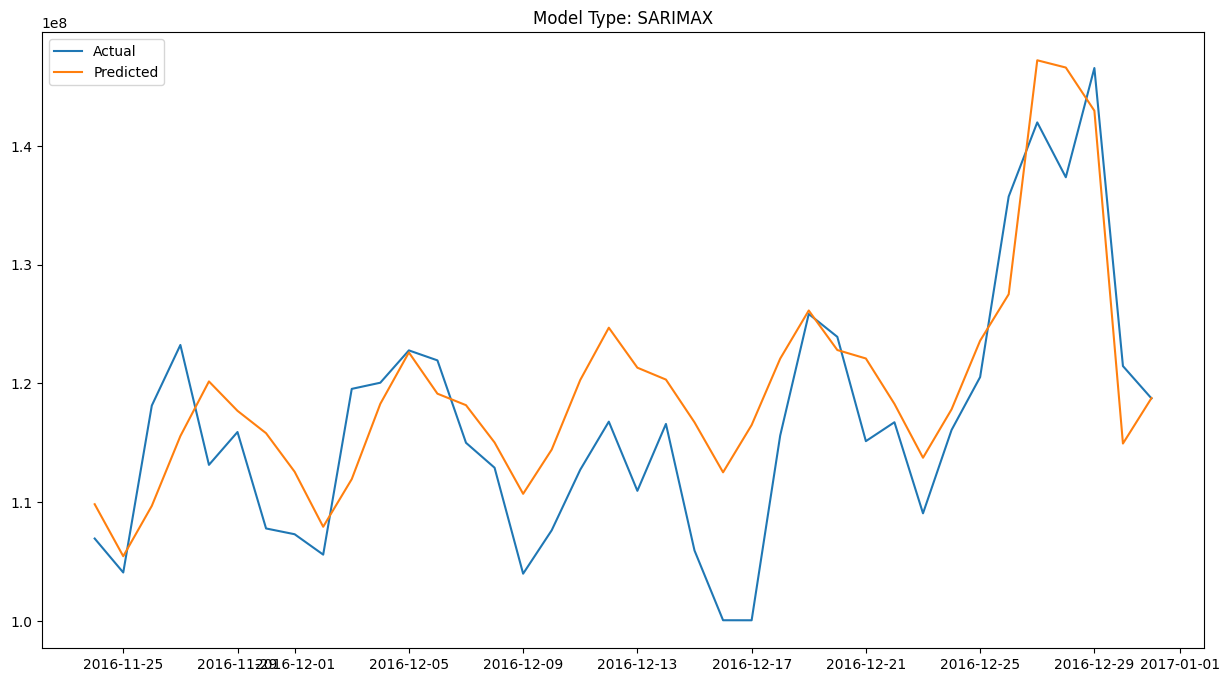

In [ ]:
#Model Sarimax
#p=5,d=1,q=5 ,  P=1,D=1,Q=1,s=7
model ,forecasts,metrics=predict_pipeline(model_type='sarimax',train_df=train_en_df, test_df=test_en_df,order_dict=(5,1,5),seasonal_order_dict=(1,1,1,7),sx_exog_train_df=train_exog_df,sx_exog_test_df=test_exog_df)

###Facebook Prophet

In [ ]:
fbp_train=pd.concat([train_en_df, train_exog_df], axis=1, join="inner")
fbp_train.reset_index(inplace=True)
fbp_train.rename(columns={'index': 'ds', 'English': 'y','Exog':'exog'}, inplace=True)

fbp_test=pd.concat([test_en_df, test_exog_df], axis=1, join="inner")
fbp_test.reset_index(inplace=True)
fbp_test.rename(columns={'index': 'ds', 'English': 'y','Exog':'exog'}, inplace=True)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---------------Evaluation Metrics---------------
MSE: 39782559206752.01
MAE: 5307422.985591489
MAPE: 0.04610433753718196


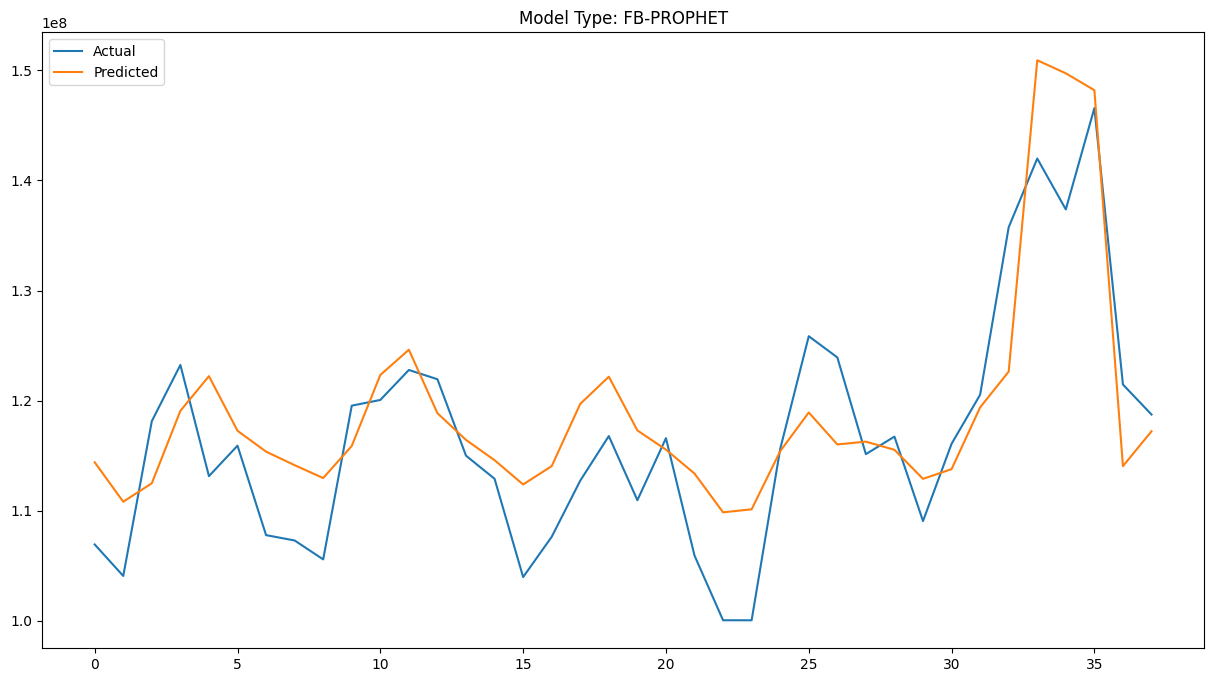

In [ ]:
model ,forecasts,metrics=predict_pipeline(model_type='fb-prophet',train_df=fbp_train, test_df=fbp_test,fb_prophet_exog_cols=['exog'])

**Observations:**
* ARIMA:
  * For (p,d,q)=(5,2,5) , Mape=5.5%
* SARIMA:
  * For (p,d,q)=(5,2,5) (P,D,Q,s)=(1,1,1,7) , Mape=10.6%
  * For (p,d,q)=(5,1,5) (P,D,Q,s)=(1,1,1,7) , Mape=6.8%
* SARIMAX:
  * For (p,d,q)=(5,2,5) (P,D,Q,s)=(1,1,1,7) , Mape=6.7%
  * For (p,d,q)=(5,2,5) (P,D,Q,s)=(1,1,1,7) , Mape=4.7%

* Facebook Prophet:
  * For prophet we have seen Mape=4.6%

#Grid Search

In [ ]:
df_agg

language,Chinese,English,French,German,Japanese,Russian,Spanish
index,,,,,,,
2015-07-01,4144975.0,84712151.0,8458626.0,13260504.0,11859424.0,9463853.0,15278552.0
2015-07-02,4151185.0,84438500.0,8512944.0,13079886.0,13618666.0,9627641.0,14601005.0
2015-07-03,4123659.0,80167665.0,8186012.0,12554018.0,12299630.0,8923456.0,13427631.0
2015-07-04,4163439.0,83463151.0,8749842.0,11520335.0,15453316.0,8393212.0,12606538.0
2015-07-05,4441273.0,86198575.0,8590461.0,13392329.0,14825358.0,8938519.0,13710354.0
...,...,...,...,...,...,...,...
2016-12-27,5522612.0,141984143.0,14246323.0,19438442.0,15600807.0,14246798.0,14512083.0
2016-12-28,5613615.0,137364144.0,13280205.0,18443376.0,15579365.0,13485931.0,15028015.0
2016-12-29,5179746.0,146565064.0,12934869.0,17951250.0,17052010.0,12976456.0,14345906.0


In [ ]:
exog_df

,Exog
index,
2015-07-01,0
2015-07-02,0
2015-07-03,0
2015-07-04,0
2015-07-05,0
...,...
2016-12-27,1
2016-12-28,1
2016-12-29,1


In [ ]:
p_values = [1, 2, 3, 4, 5]
d_values = [1, 2]
q_values = [1, 2, 3, 4, 5]

# P_values = [0, 1]
# D_values = [0, 1]
# Q_values = [0, 1]

# s = 7

In [ ]:
def fit_forecast_arima(
    train_y,
    val_y,
    order
):
    model = SARIMAX(
        train_y,
        order=order
    )

    model_fit = model.fit(disp=False,maxiter=200)

    if not model_fit.mle_retvals.get("converged", False):
        raise RuntimeError("Model did not converge")

    forecast = model_fit.forecast(
        steps=len(val_y)
    )

    return forecast


In [ ]:
def fit_forecast_sarimax(
    train_y, train_exog,
    val_y,   val_exog,
    order, seasonal_order
):
    model = SARIMAX(
        train_y,
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    model_fit = model.fit(disp=False,maxiter=200)

    if not model_fit.mle_retvals.get("converged", False):
        raise RuntimeError("Model did not converge")

    forecast = model_fit.forecast(
        steps=len(val_y),
        exog=val_exog
    )

    return forecast


In [ ]:
def process_arima_grid_search(lang):
    local_results = []

    try:
        print(f"Processing language: {lang}\n")

        # Target series
        df_lang = df_agg[lang]
        df_lang.index = pd.to_datetime(df_lang.index)
        df_lang = df_lang.asfreq("D")

        # --- Train / Test ---
        train_cv_df, test_df, _, _ = sequential_train_test_split(
            df=df_lang,
            exog_df=None,
            test_split_ratio=0.07
        )

        # --- Train / CV ---
        train_df, cv_df, _, _ = sequential_train_test_split(
            df=train_cv_df,
            exog_df=None,
            test_split_ratio=0.07
        )

        for p in p_values:
            for d in d_values:
                for q in q_values:

                    order = (p, d, q)

                    try:
                        # -------- TRAIN → CV --------
                        cv_forecast = fit_forecast_arima(
                            train_df,
                            cv_df,
                            order
                        )

                        _, _, cv_mape = evaluation_metrics(
                            cv_df.values,
                            cv_forecast.values
                        )

                        # -------- TRAIN+CV → TEST --------
                        test_forecast = fit_forecast_arima(
                            train_cv_df,
                            test_df,
                            order
                        )

                        _, _, test_mape = evaluation_metrics(
                            test_df.values,
                            test_forecast.values
                        )

                        local_results.append({
                            "language": lang,
                            "order": order,
                            "cv_mape": cv_mape,
                            "test_mape": test_mape,
                            "failed": False,
                            "error": np.nan
                        })

                    except Exception as e:
                        local_results.append({
                            "language": lang,
                            "order": order,
                            "cv_mape": np.nan,
                            "test_mape": np.nan,
                            "failed": True,
                            "error": str(e)
                        })
                        continue

        print("-----------------------------------------------------------")
        return local_results

    except Exception as e:
        print(f"Error processing language: {lang} → {e}")
        return []


In [ ]:
from joblib import Parallel, delayed

languages = df_agg.columns.tolist()
all_results = Parallel(
  n_jobs=len(languages),
  backend="loky",
  verbose=10
)(
  delayed(process_arima_grid_search)(lang)
  for lang in languages
)


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed: 11.1min
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed: 11.1min remaining: 27.9min
[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed: 11.3min remaining: 15.1min
[Parallel(n_jobs=7)]: Done   4 out of   7 | elapsed: 11.9min remaining:  8.9min
[Parallel(n_jobs=7)]: Done   5 out of   7 | elapsed: 12.0min remaining:  4.8min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed: 12.3min finished


In [ ]:
results = [row for lang_res in all_results for row in lang_res]

results_df = pd.DataFrame(results)

In [ ]:
tmp_result=results_df[results_df['failed'] == False]
highest_mape_per_lang = tmp_result.loc[tmp_result.groupby('language')['test_mape'].idxmin()]
highest_mape_per_lang = highest_mape_per_lang.reset_index(drop=True)
highest_mape_per_lang

,language,order,cv_mape,test_mape,failed,error
0,Chinese,"(4, 1, 5)",0.045684,0.043927,False,NaN
1,English,"(5, 2, 5)",0.066403,0.055178,False,NaN
2,French,"(5, 1, 3)",0.081163,0.068223,False,NaN
3,German,"(5, 1, 4)",0.055994,0.064791,False,NaN
4,Japanese,"(2, 1, 4)",0.056019,0.074855,False,NaN
5,Russian,"(1, 1, 3)",0.095736,0.056809,False,NaN
6,Spanish,"(4, 2, 4)",0.076786,0.205643,False,NaN


In [ ]:
tmp_result=results_df[results_df['failed'] == False]
tmp_result['avg_mape']=(tmp_result['cv_mape']+tmp_result['test_mape'])/2
highest_mape_per_lang = tmp_result.loc[tmp_result.groupby('language')['avg_mape'].idxmin()]
highest_mape_per_lang = highest_mape_per_lang.reset_index(drop=True)

highest_mape_per_lang

,language,order,cv_mape,test_mape,failed,error,avg_mape
0,Chinese,"(4, 1, 5)",0.045684,0.043927,False,NaN,0.044806
1,English,"(5, 2, 5)",0.066403,0.055178,False,NaN,0.060790
2,French,"(5, 1, 5)",0.071388,0.072191,False,NaN,0.071789
3,German,"(5, 1, 4)",0.055994,0.064791,False,NaN,0.060392
4,Japanese,"(2, 1, 4)",0.056019,0.074855,False,NaN,0.065437
5,Russian,"(3, 1, 5)",0.051227,0.067396,False,NaN,0.059311
6,Spanish,"(4, 2, 4)",0.076786,0.205643,False,NaN,0.141214


Processing language: Chinese


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 90472241427.67793
MAE: 218892.74458756333
MAPE: 0.0398604780766136


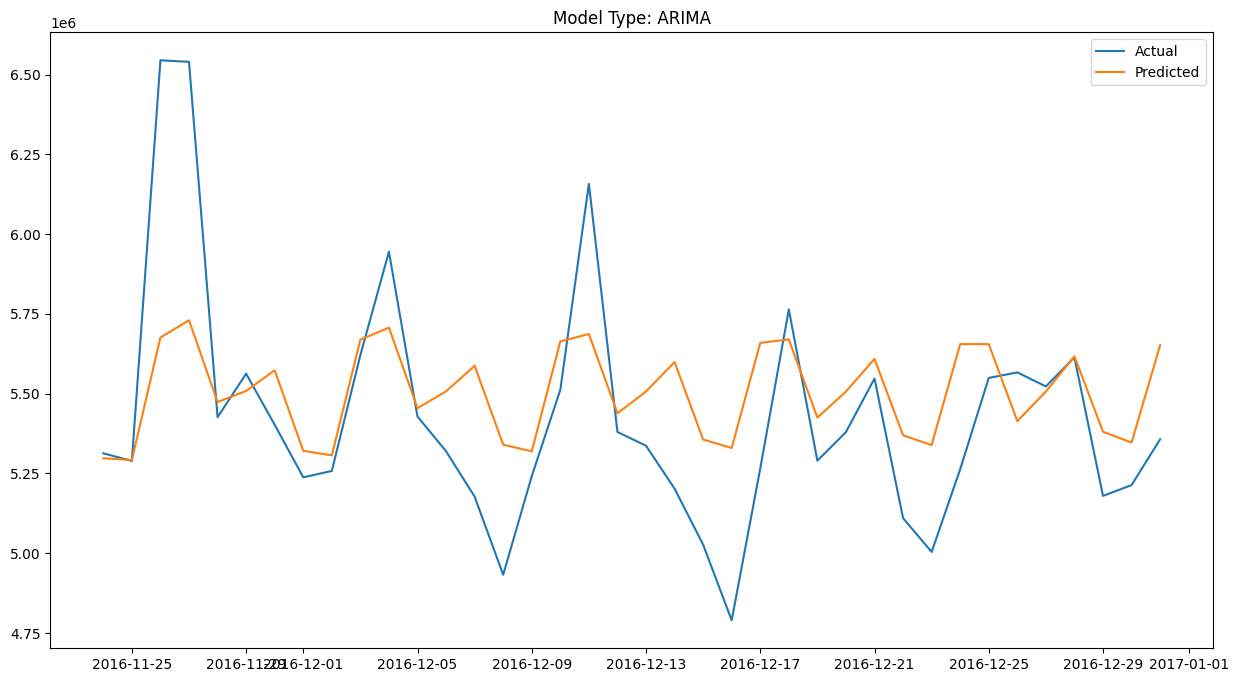

Processing language: English


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 75223049744796.75
MAE: 6577762.161572939
MAPE: 0.05562479509279944


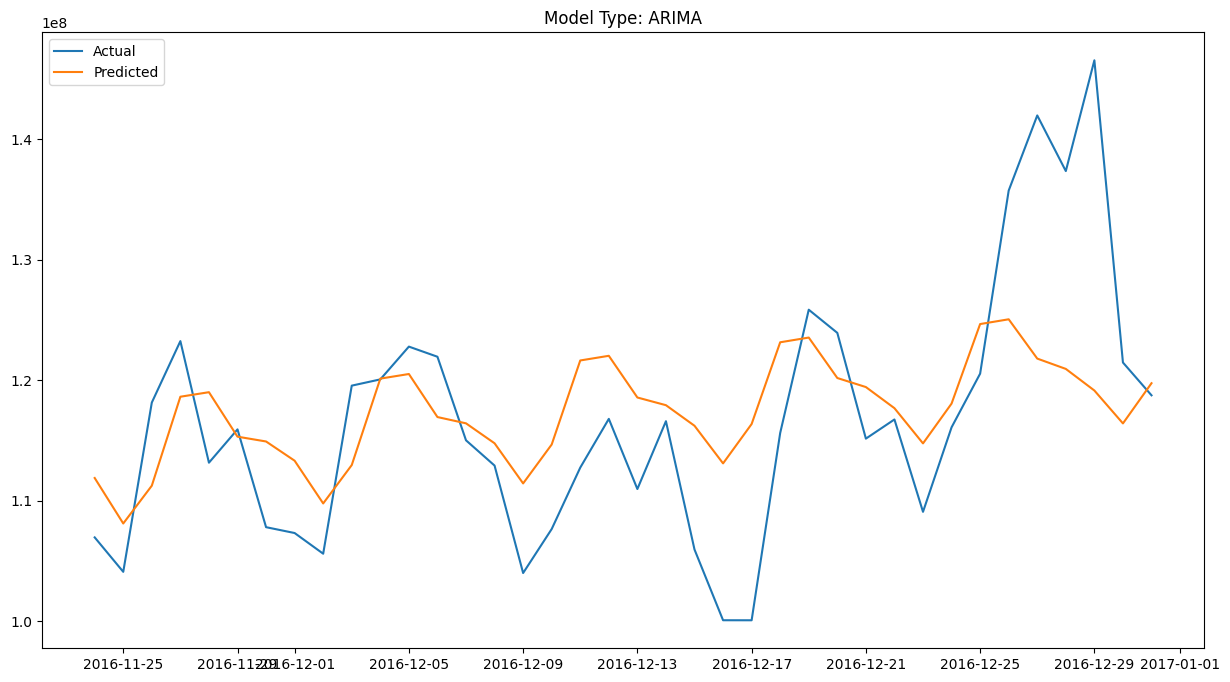

Processing language: French


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 1732888789688.7454
MAE: 936524.2716864757
MAPE: 0.07243986843641362


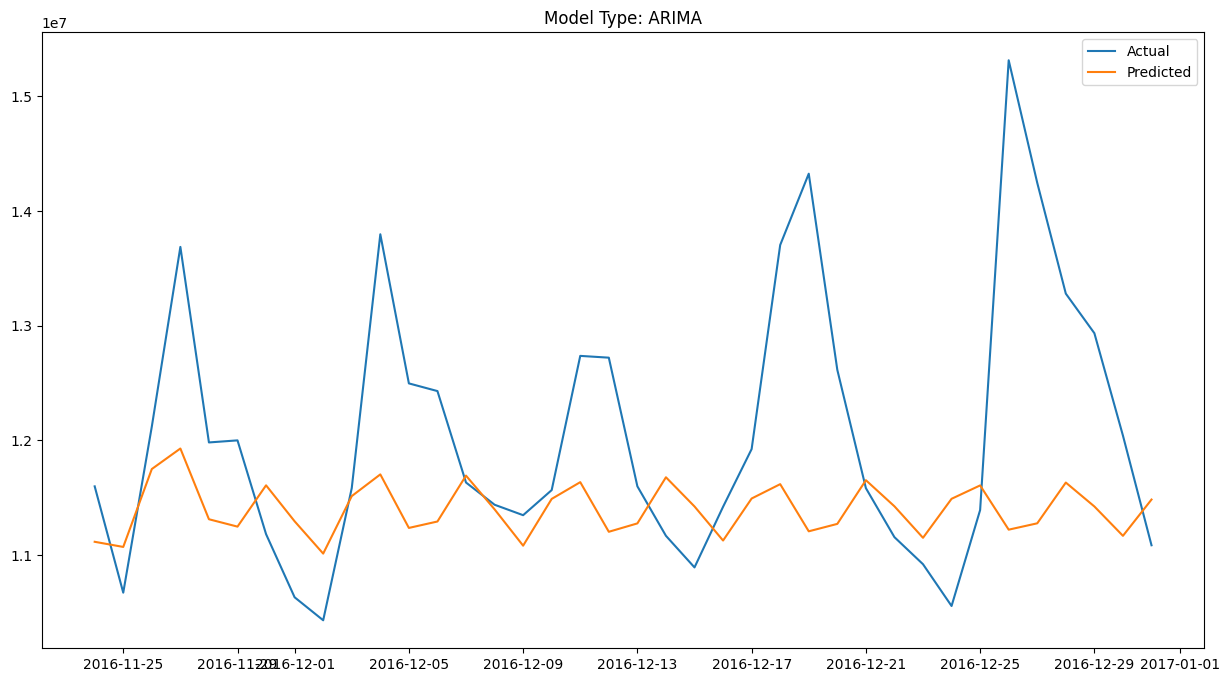

Processing language: German


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 3734261717083.1826
MAE: 1193120.2347575605
MAPE: 0.06583547978217758


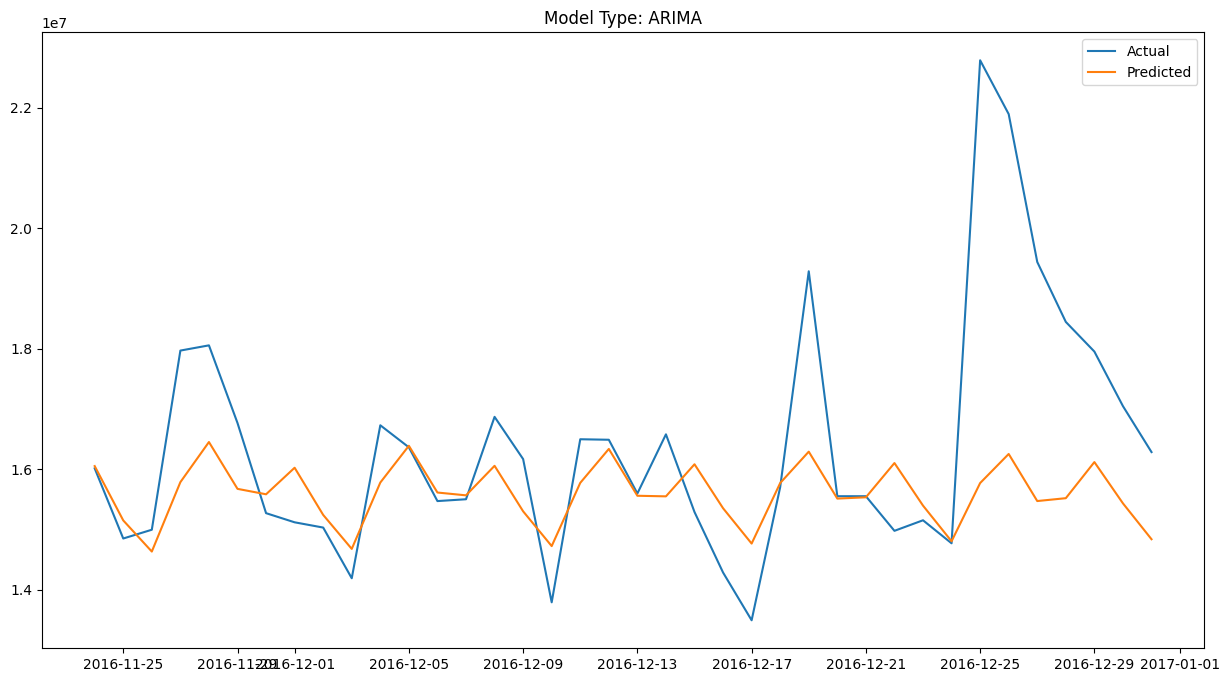

Processing language: Japanese


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 4066132441101.4917
MAE: 1275673.3422004252
MAPE: 0.07464671326113159


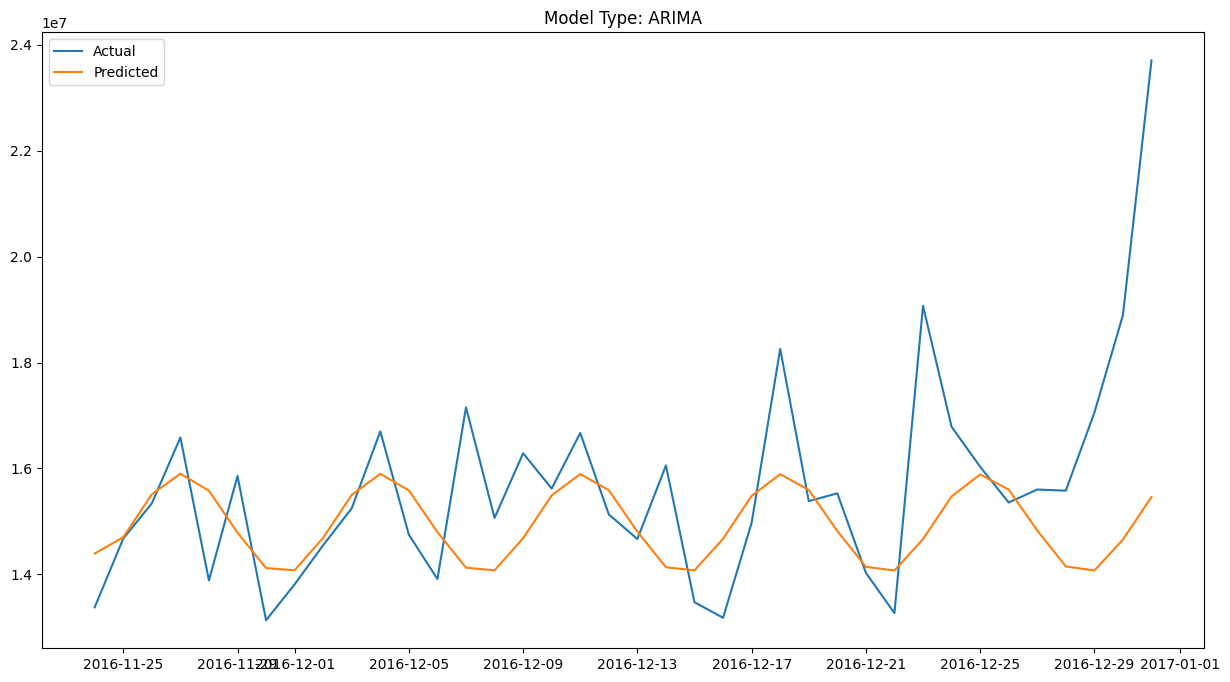

Processing language: Russian


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



---------------Evaluation Metrics---------------
MSE: 1426604653248.1238
MAE: 906243.4615040516
MAPE: 0.06237648746522441


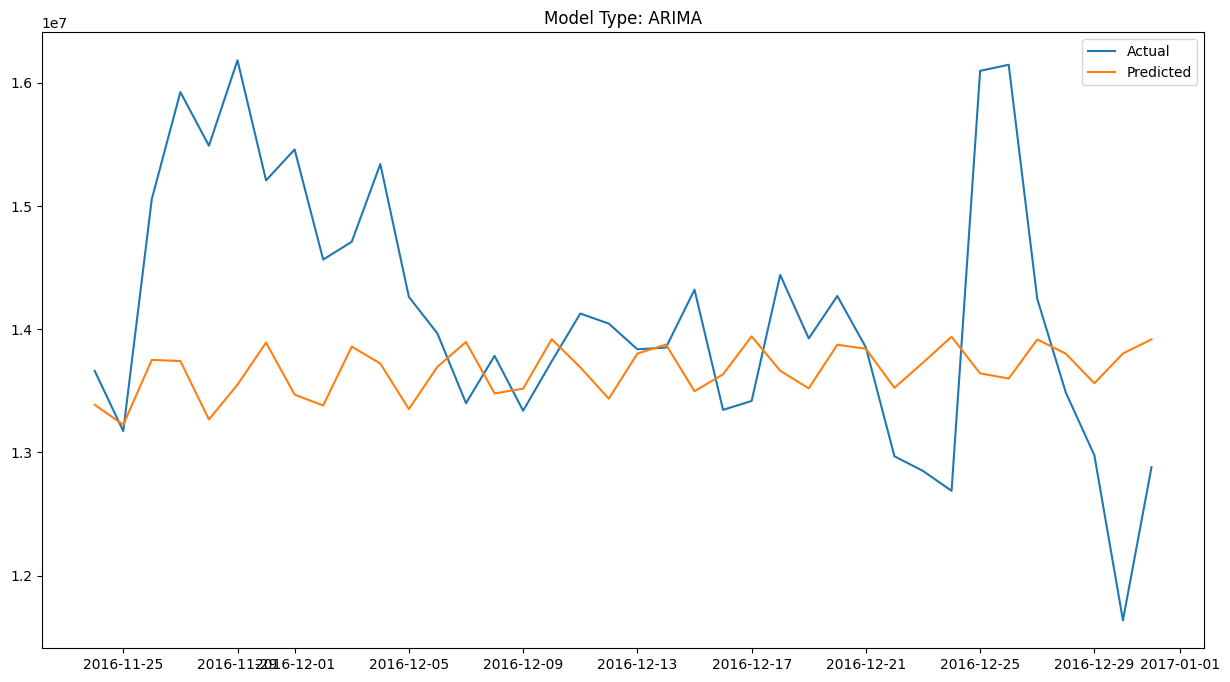

Processing language: Spanish
---------------Evaluation Metrics---------------
MSE: 10238320316341.658
MAE: 2834318.500339715
MAPE: 0.20564310090129884


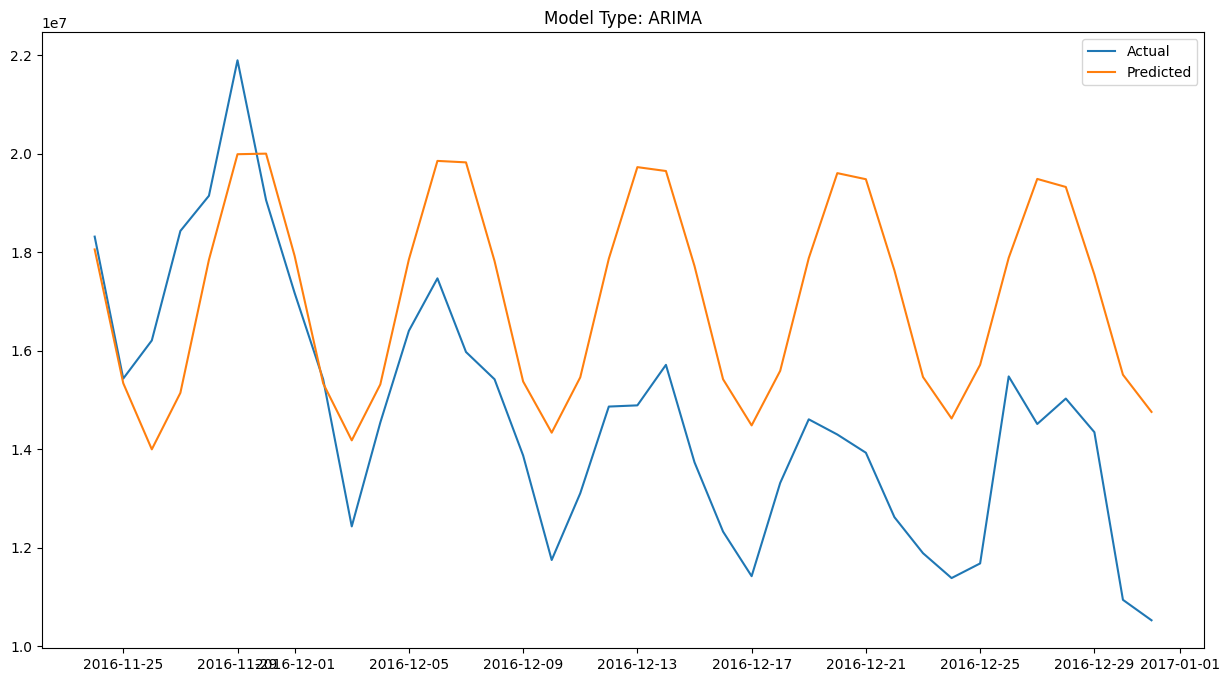

In [ ]:
def process_arima(df):
    try:

        for idx, row in df.iterrows():
            lang = row['language']  # assuming 'language' is the column name
            print(f"Processing language: {lang}")

            df_lang = df_agg[lang]
            df_lang.index = pd.to_datetime(df_lang.index)
            df_lang = df_lang.asfreq("D")

            # # --- Train / Test split---
            train_df, test_df, _, _ = sequential_train_test_split(
                df=df_lang,
                exog_df=None,
                test_split_ratio=0.07
            )
            order=row['order']
            model ,forecasts,metrics=predict_pipeline(model_type='arima',train_df=train_df, test_df=test_df,order_dict=order)
    except Exception as e:
        print(f"Error processing language: {lang} → {e}")
process_arima(highest_mape_per_lang)

In [ ]:
#time consuming
# results =[]
# def process_sarimax_grid_search(lang):
#     local_results = []
#     try:
#         print(f"Processing language: {lang}\n")

#         # Target series
#         df_lang = df_agg[lang]
#         df_lang.index = pd.to_datetime(df_lang.index)
#         df_lang = df_lang.asfreq('D')
#         # --- Train / Test ---
#         train_cv_df, test_df, train_cv_exog_df, test_exog_df = sequential_train_test_split(
#             df=df_lang,
#             exog_df=exog_df,
#             test_split_ratio=0.07
#         )

#         # --- Train / CV ---
#         train_df, cv_df, train_exog_df, cv_exog_df = sequential_train_test_split(
#             df=train_cv_df,
#             exog_df=train_cv_exog_df,
#             test_split_ratio=0.07
#         )

#         for p in p_values:
#             for d in d_values:
#                 for q in q_values:
#                     for P in P_values:
#                         for D in D_values:
#                             for Q in Q_values:

#                                 order = (p, d, q)
#                                 seasonal_order = (P, D, Q, s)

#                                 try:
#                                     # -------- TRAIN → CV --------
#                                     cv_forecast = fit_forecast_sarimax(
#                                         train_df, train_exog_df,
#                                         cv_df, cv_exog_df,
#                                         order, seasonal_order
#                                     )

#                                     _, _, cv_mape = evaluation_metrics(cv_df.values, cv_forecast.values)


#                                     test_forecast = fit_forecast_sarimax(
#                                         train_cv_df, train_cv_exog_df,
#                                         test_df, test_exog_df,
#                                         order, seasonal_order
#                                     )

#                                     _, _, test_mape = evaluation_metrics(test_df.values, test_forecast.values)

#                                     local_results.append({
#                                         "language": lang,
#                                         "order": order,
#                                         "seasonal_order": seasonal_order,
#                                         "cv_mape": cv_mape,
#                                         "test_mape": test_mape,
#                                         "failed": False,
#                                         "error": np.nan
#                                     })

#                                     #print(f"* (p,d,q): {order},  (P,D,Q,s): {seasonal_order}, cv_mape: {cv_mape}, test_mape: {test_mape}")

#                                 except Exception as e:
#                                     local_results.append({
#                                         "language": lang,
#                                         "order": order,
#                                         "seasonal_order": seasonal_order,
#                                         "cv_mape": np.nan,
#                                         "test_mape": np.nan,
#                                         "failed": True,
#                                         "error": str(e)
#                                     })
#                                     continue
#         print(f"-----------------------------------------------------------")
#         return local_results
#     except Exception as e:
#         print(f"Error processing language: {lang}")
#         return []

# #process_grid_search('English')

#Recommendations:

* English pages clearly dominate in terms of traffic volume while also exhibiting low MAPE, indicating stable and reliable forecasts. As a result, maximum advertisement investment should be allocated to English pages to maximize reach and ROI.

* Chinese pages record the lowest number of visits among all languages. Advertising on these pages should generally be de-prioritized, unless there is a targeted marketing strategy specifically aimed at Chinese audiences.

* French, German, and Japanese pages fall into a mid-tier category, with moderate traffic levels and moderate forecast accuracy (MAPE). These languages are suitable for balanced advertising investment with controlled budgets.

* Spanish pages show the second-highest traffic volume despite having the fewest pages, indicating strong demand concentration. However, they also exhibit the highest MAPE, suggesting greater volatility and forecasting uncertainty. Advertising on Spanish pages can yield high reach, but requires cautious budget allocation and more robust forecasting models.


**3 inferences made from the data visualizations**
* English views are 5–7× higher than any other language and show clear seasonal peaks (Q3) and sharp volume swings.
* Russian traffic is highly volatile, indicating event-driven behavior
* Spanish consistently leads non-English languages in total views while maintaining low volatility and steady growth. This makes it a high-confidence, high-ROI language segment for sustained ad placement and reliable forecast-based optimization.

**Compare the number of views in different languages.**

English language is a clear winner. English > Spanish > German > Japenese > Russian > French > Chinese, in terms of views.

**Other methods other than grid search would be suitable to get the model for all languages?**

Auto-ARIMA, Bayesian Optimization or XG-BOOST
